In [1]:
import numpy as np
import mne
from mne.time_frequency import psd_multitaper, psd_welch
import pandas as pd
import pickle
import tqdm 
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pathlib import Path
from itertools import chain, repeat

# composite Simpson's rule
from scipy.integrate import simpson

# Import some NeuroDSP functions to use with MNE
from neurodsp.spectral import trim_spectrum

# FOOOF imports
from fooof.bands import Bands

import os

In [2]:
mne.set_log_level(False)
mne.utils.set_config('MNE_USE_CUDA', 'true')  
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
NUM_BLOCKS = 7

channel_groups =[['F3', 'F4'],['F3', 'F4', 'C3', 'C4'],['P3', 'Pz', 'P4'],['F3','C3','P3','P4','C4','F4','Pz']]
ch_names = ['Time', 'F3','C3','P3','P4','C4','F4','Pz', 'BlockNumber']
ch_types = ['misc', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',  'misc']

s_freqs = 300

bands = Bands({'theta': [4, 8], 'alpha': [8, 12]})   
 
plot_plots = False       
save_plots = False
draw_plots = False

# bad channels
# TODO fill for all participants and blocks :')
# Format: bads[pid][block]
# example : bads[pid=1] = [['F2', 'F3'], [], ['C4'], [], [], [],  []]

bads = [[[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []],
        [[], [], [], [], [], [],  []]
]

In [4]:
# ICA template. 
# import pickle if it exists else run script and create template
ica_templates = []
ica_excludes = []

Path('./ica/').mkdir(parents=True, exist_ok=True)
Path('./ica/fifs').mkdir(parents=True, exist_ok=True)

count = 0
dir_path = r'./ica/'
for path in os.scandir(dir_path):
    if path.is_file():
        count += 1
count /= 2
for f in range(int(count)):
    try:
        with open('./ica/ica_template-' + str(int(f)) + '.pickle', 'rb') as inp:
            ica_template = pickle.load(inp)
            ica_templates.append(ica_template)
    except Exception as e:
        print(e)
        ica_template = None
    try:
        with open('./ica/exclude-' + str(int(f)) + '.pickle', 'rb') as inp:
            ica_exclude = pickle.load(inp)
            ica_excludes.append(ica_exclude)
    except Exception as e:
        print(e)
        ica_exclude = None
    
#all ICAs to compute
icas = []
icas_dict = {}
raws_dict = {}
clean_raws = {}

In [5]:
lstPIds = []
path = "../Data/"
for filename in os.listdir(path):
    if filename.endswith(".csv"): 
        lstPIds.append(int(filename.split("-")[0].replace("ID", "")))
    else:
        continue
lstPIds = list(set(lstPIds))
print(lstPIds)
print(str(len(lstPIds)) + " subjects")

[1, 2, 3, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
17 subjects


In [6]:
arr_raws = []

dir_path = r'./fifs/'
Path(dir_path).mkdir(parents=True, exist_ok=True)

if len(os.listdir('./fifs')) != NUM_BLOCKS * len(lstPIds):
    for pid in tqdm.tqdm(lstPIds):

        # if (pid != 16):
        #     continue
        # if (pid > 2):
        #         break

        dfState = pd.read_csv(f"{path}ID{pid}-state.csv")
        dfState = pd.read_csv(f"{path}ID{pid}-state.csv")
            
        dfEEG = pd.read_csv(f"{path}ID{pid}-EEG.csv")
        dfEEG = dfEEG.rename(columns={"Value0": "F3", "Value1": "C3", "Value2": "P3", "Value3": "P4", "Value4": "C4", "Value5": "F4", "Value6": "Pz"})
        dfEEG.drop("TimeLsl", axis =1, inplace=True)

        dstate = pd.read_csv(f"{path}ID{pid}-state.csv")

        dfAll = pd.merge(dfEEG, dstate, on =["Time"], how="outer")
        dfAll = dfAll.sort_values(by="Time") # inplace?

        dfAll = dfAll.drop(columns=["Value7","AdaptationStatus", "NBackN", "State"] )
        dfAll.fillna(method='ffill', inplace=True)
        dfAll = dfAll.drop(dfAll[dfAll.BlockNumber < 0].index)
        dfAll = dfAll.dropna()
            

        for x in range(1, NUM_BLOCKS+1):  
            
            # if(x > 2):
            #     continue
            
            # Prepare data 
            data = dfAll.loc[dfAll['BlockNumber'] == x]
            df = pd.DataFrame(data)
            # data.plot(x="Time", y=["F3", "C3","P3","P3","C4","F4","Pz"])

            sfreq=300 # i really think its 300 -.-
            info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
            info.set_montage('standard_1020',  match_case=False)

            samples = df.T
            
            raw = mne.io.RawArray(samples, info)
            raw.drop_channels(['Time', 'BlockNumber'])
            
            #high pass filter to remove slow drifts, 70 Hz low pass
            #raw.filter(1., 70., None, fir_design='firwin')
            #TODO im using .1 not 1.?
            raw.filter(.1, 70, None, fir_design='firwin')

            #remove power line interferance
            raw.notch_filter(50, n_jobs=-1)
            
            # set eeg reference
            raw.set_eeg_reference('average', projection=True)
            
            # Visual inspection of bad channels
            # TODO, empty list for now. With new setup, check for bad channels only once for all blocks.
            raw.info['bads'] =  bads[pid-1][x-1]
            raw.interpolate_bads()
            
            #arr_raws.append(raw)
            raw.save('./fifs/' + str(pid) + '-' + str(x) + '_eeg.fif', overwrite = False)

In [7]:
exclude_ic = [] # TODO sure its here?
pick_ic_as_template = True
action = None

for pid in tqdm.tqdm(lstPIds):
    
    if action == 'no':
        pick_ic_as_template = False
    else:
        valid_response = {'no', 'yes'} 
        prompts = chain(["Select ICs for ICE corrmap? - ENTER | no"], repeat("Type ENTER or \"no\": "))
        replies = map(input, prompts)
        lowercased_replies = map(str.lower, replies)
        stripped_replies = map(str.strip, lowercased_replies)
        action = next(filter(valid_response.__contains__, stripped_replies))
        #action = input("Select ICs for ICE corrmap? - ENTER | no")
        
        if action == 'no':
            pick_ic_as_template = False
    
    for x in range(1, NUM_BLOCKS+1):  
        
        raw = mne.io.read_raw_fif('./fifs/' + str(pid) + '-' + str(x) + '_eeg.fif')
          
        # # independent component analysis (ICA)        
        ica = mne.preprocessing.ICA(method="infomax",max_iter='auto')
        
        raw.load_data()
        
        
        # should probably delete contents first but hey
        if len(os.listdir('./ica/fifs/')) != NUM_BLOCKS * len(lstPIds):
            # independent component analysis (ICA)
            ica = mne.preprocessing.ICA(method="fastica", n_components=5, random_state=97, max_iter='auto')

            raw.load_data()
            ica.fit(raw)
            
            ica.save('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif', overwrite = True)
            
        else:
            ica = mne.preprocessing.read_ica('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif')

        # Pick templates
        #TODO put this in separate script.
        if(pick_ic_as_template):
            
            ica.plot_sources(raw, block = True)
            
            exclude_ic = ica.exclude
            #ica.exclude = [] # avoid excluding it twice. or i guess not? i has no idea.
            
            ica.plot_overlay(raw, exclude=exclude_ic, picks='eeg')

            ready_to_write = True 
            if(ready_to_write):
                count = 0
                dir_path = r'./ica/'
                for path in os.scandir(dir_path):
                    if path.is_file():
                        count += 1
                count /= 2
                
                with open('./ica/ica_template-' + str(int(count)) + '.pickle', 'wb') as f:
                    pickle.dump(ica, f)
                with open('./ica/exclude-'+ str(int(count)) + '.pickle', 'wb') as f:
                    pickle.dump(exclude_ic, f)
                
                #TODO maybe do a size check before appending    
                ica_templates.append(ica)
                ica_excludes.append(exclude_ic)
        
        # save the ICAs for the corrmap 
        #else:

        icas.append(ica)
        arr_raws.append(raw)

        # raw.save("./ica/pipeline_1/raw/"+str(pid)+"_"+str(x)+".fif")

100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


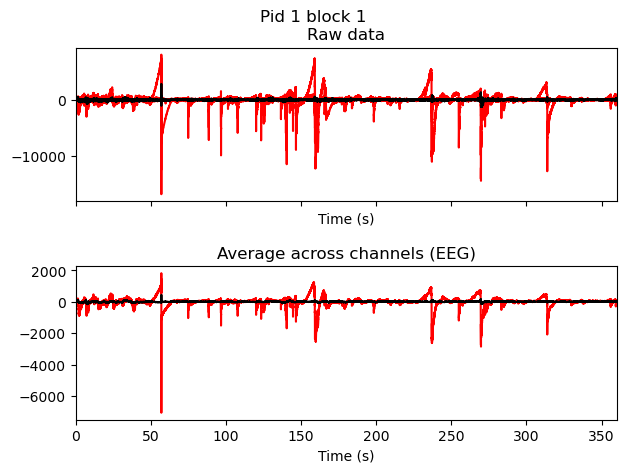

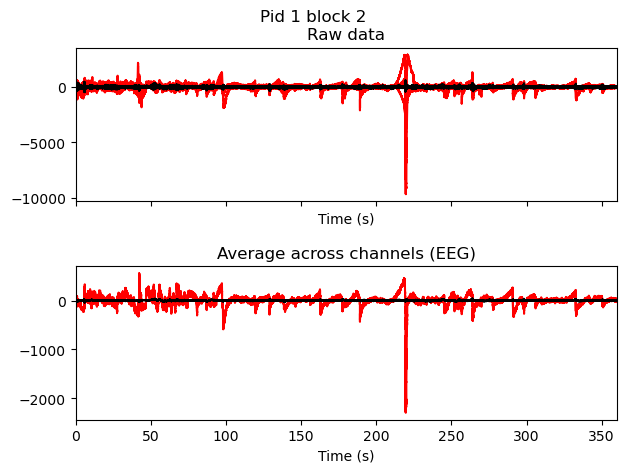

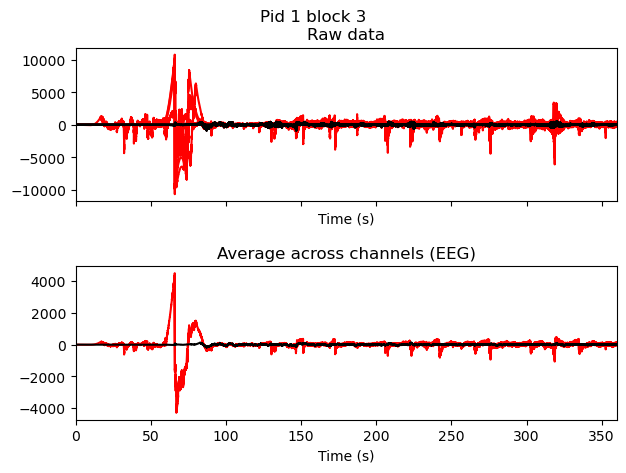

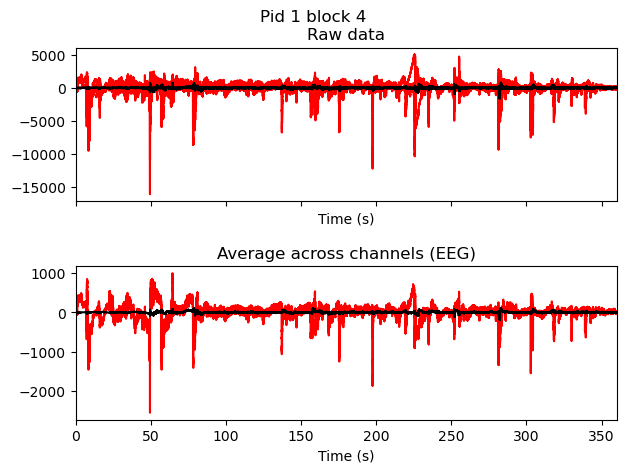

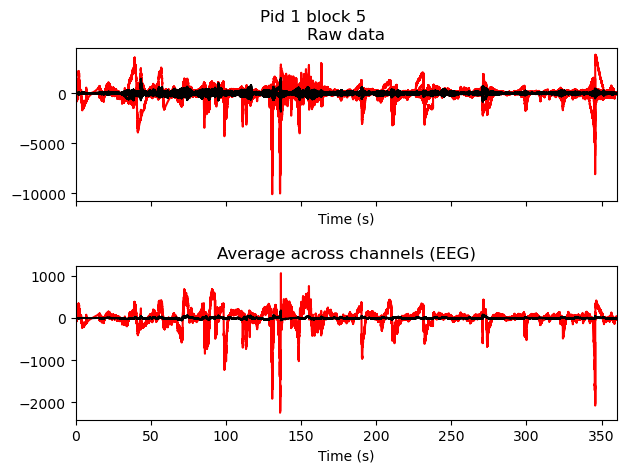

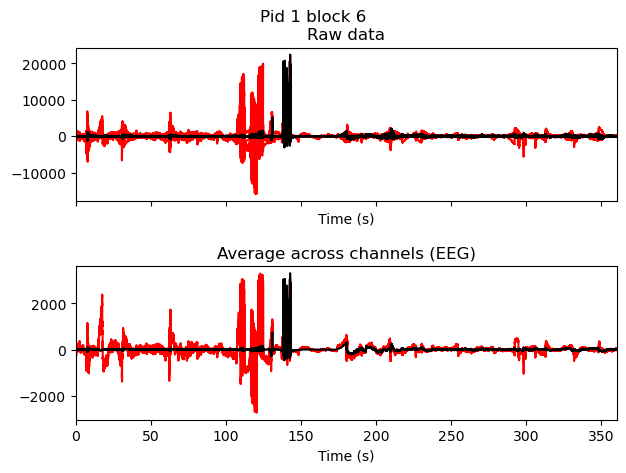

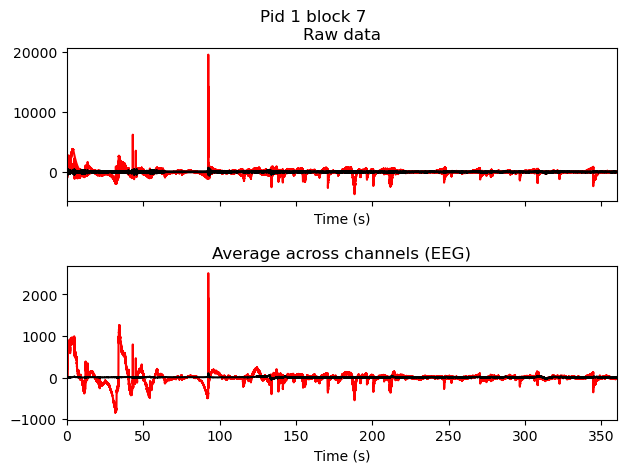

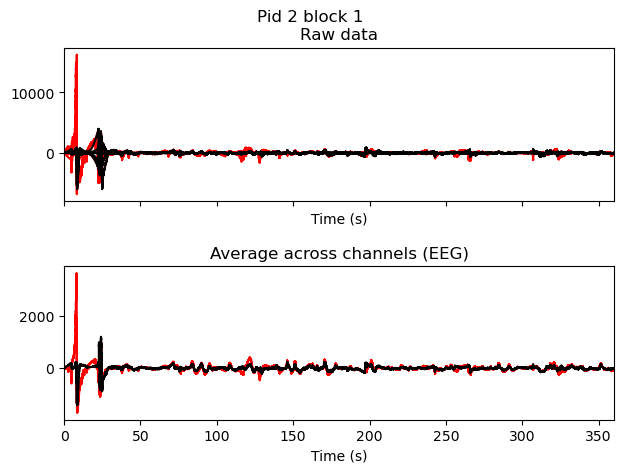

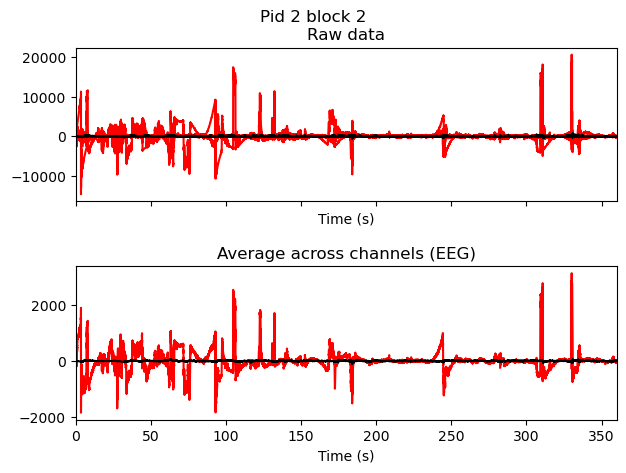

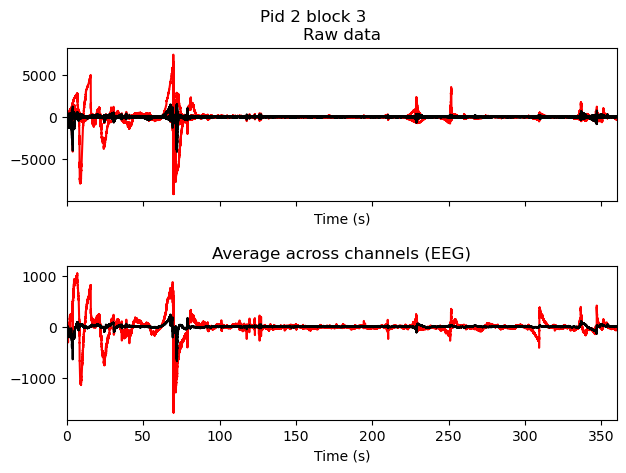

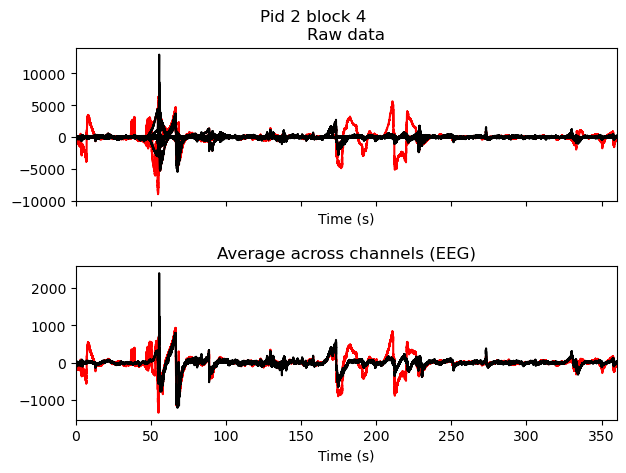

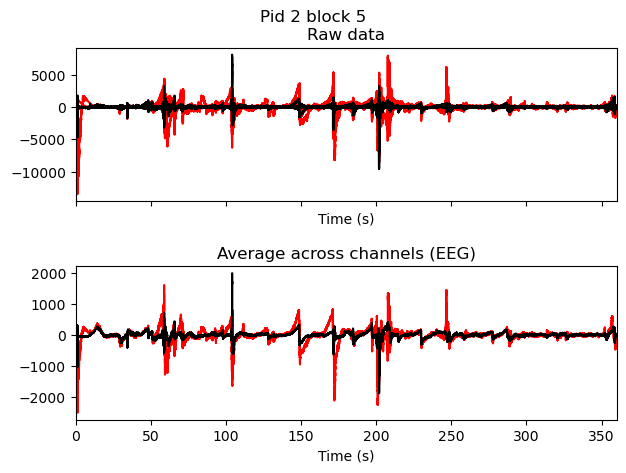

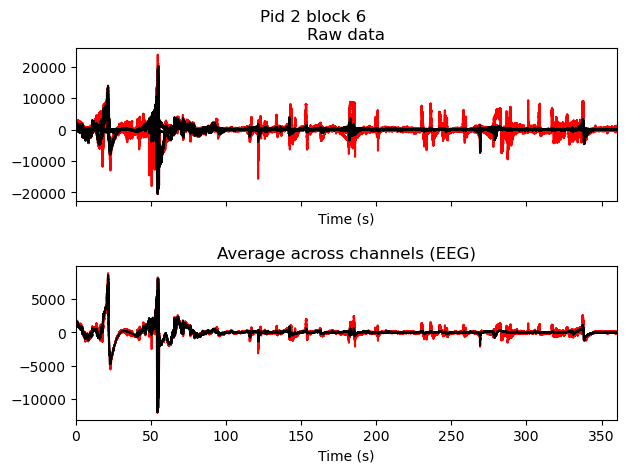

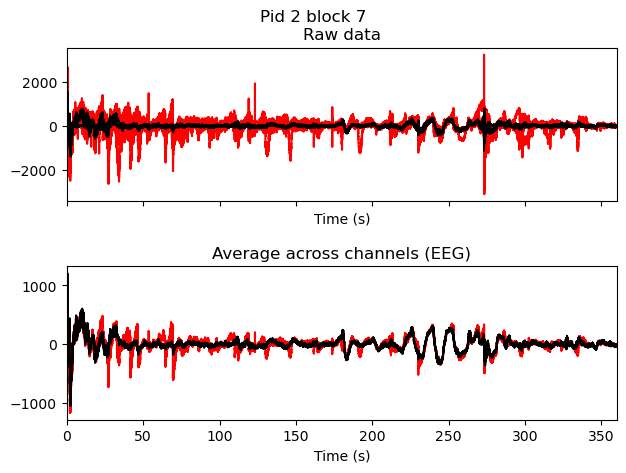

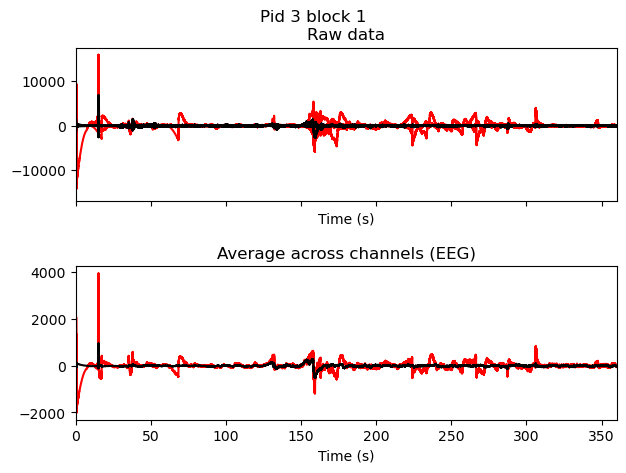

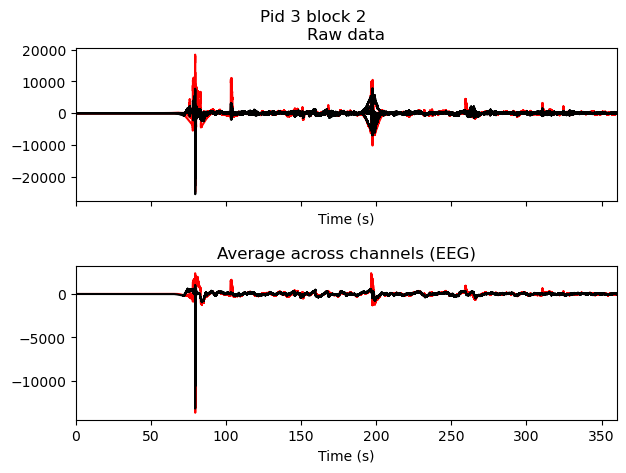

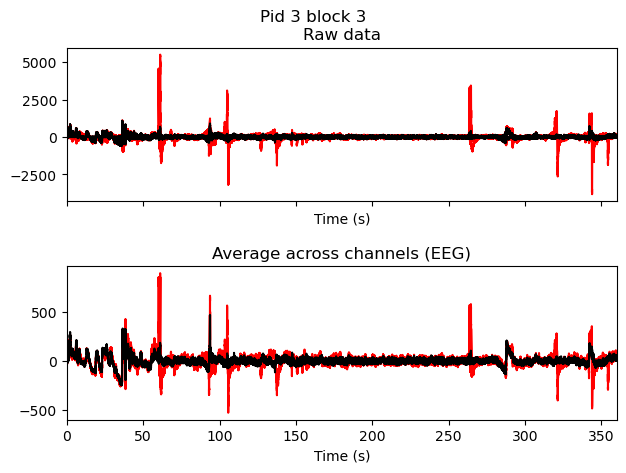

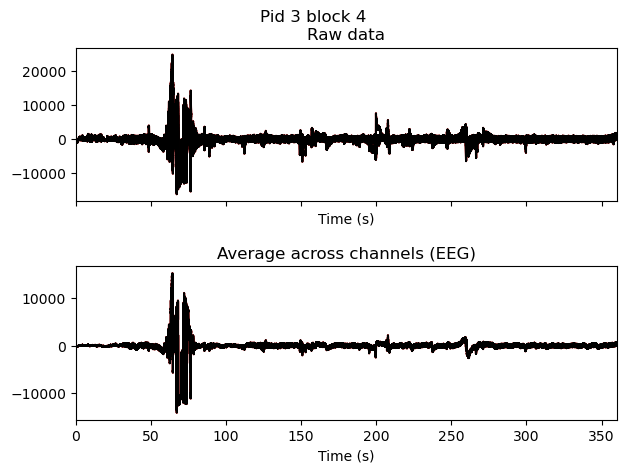

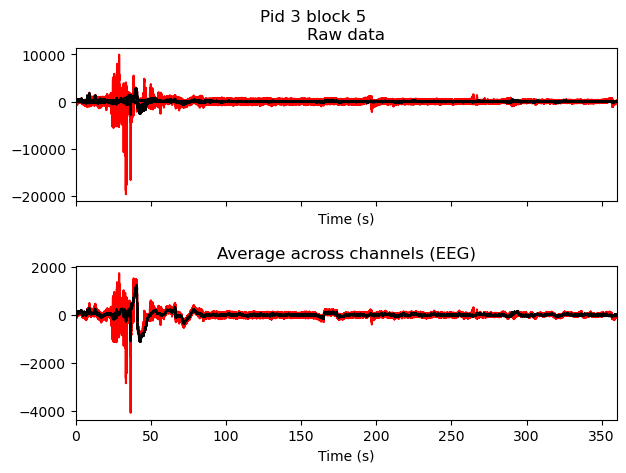

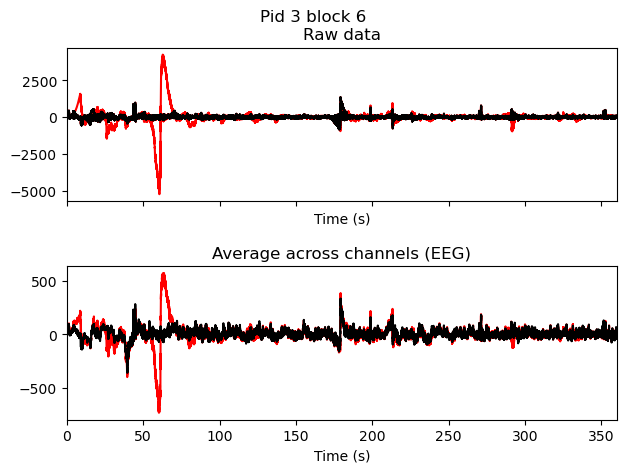

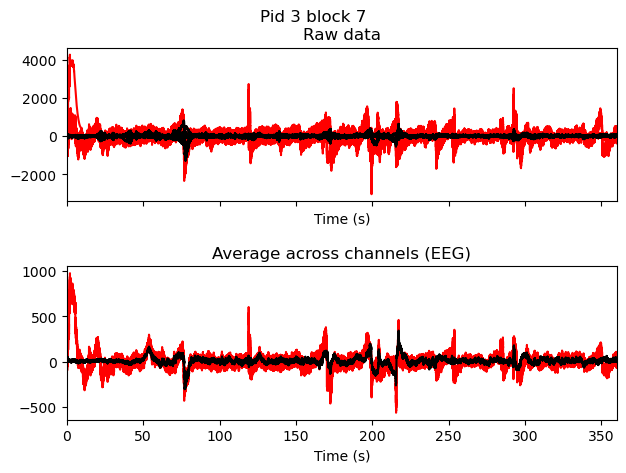

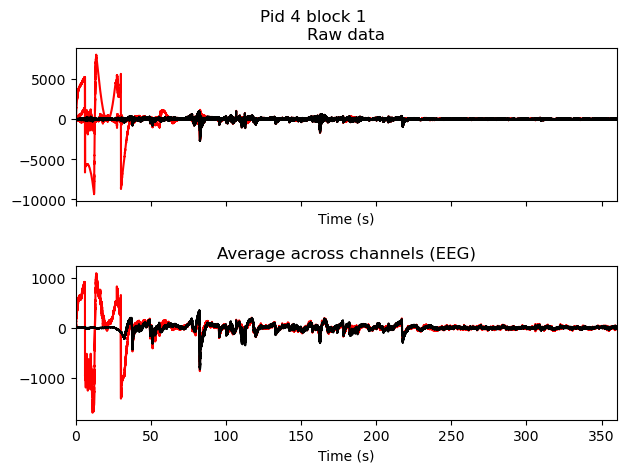

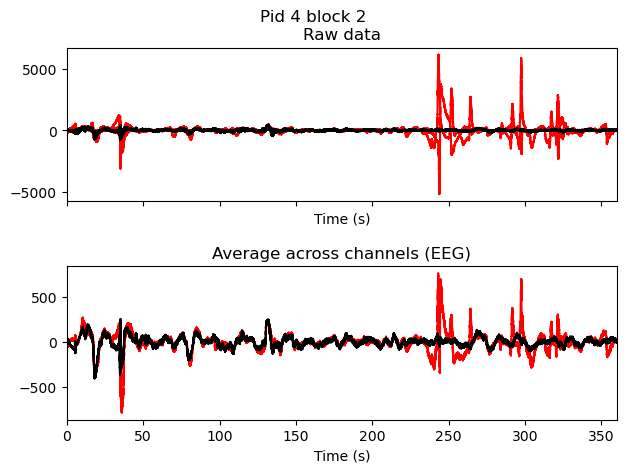

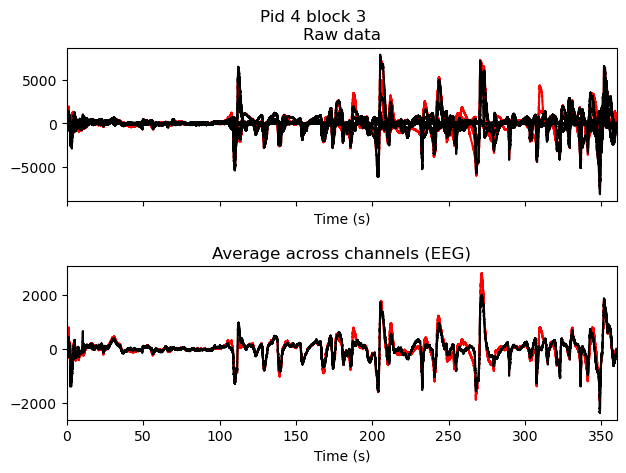

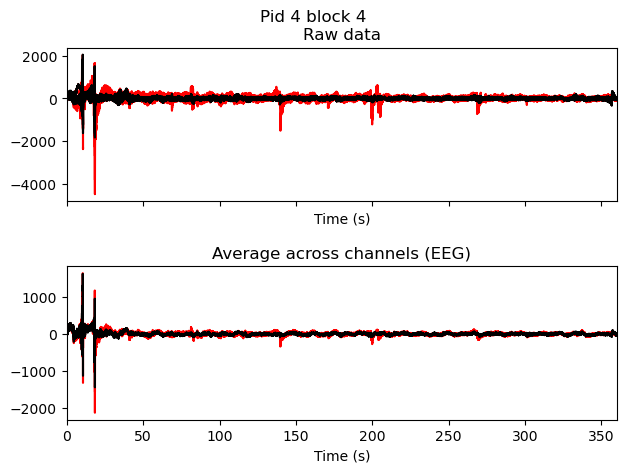

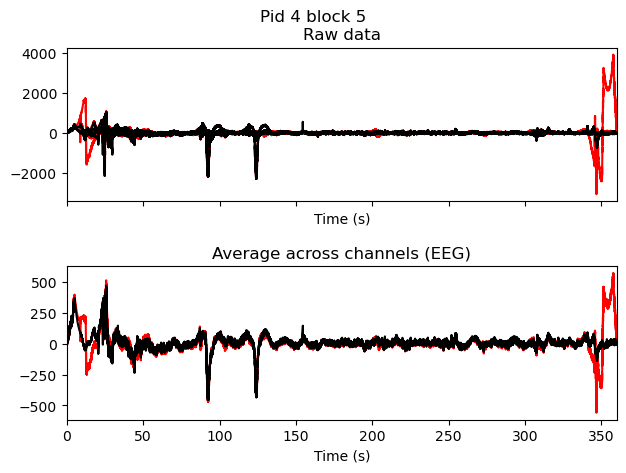

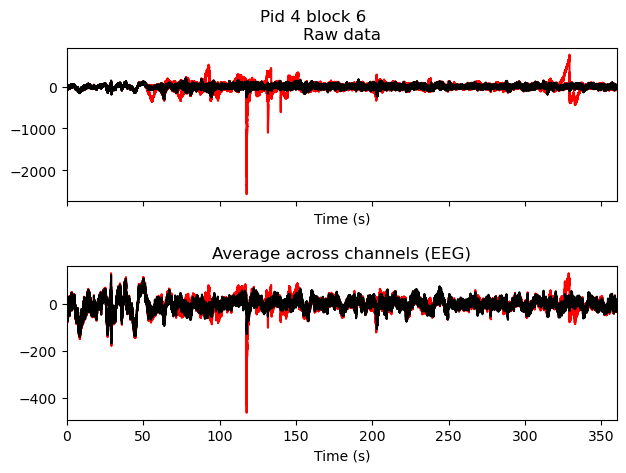

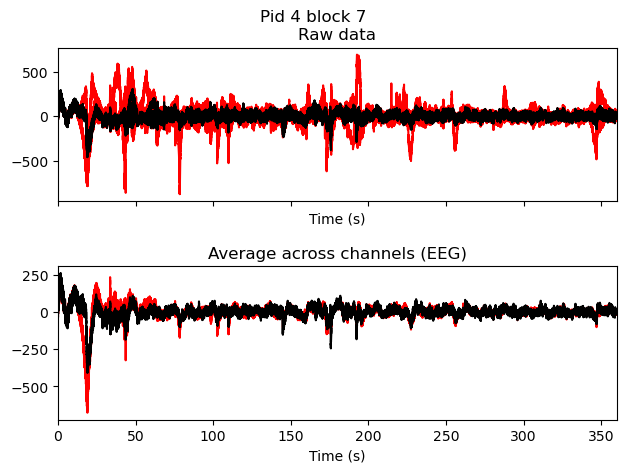

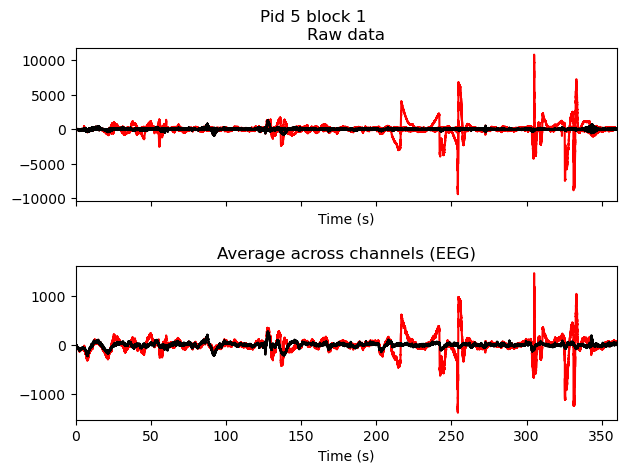

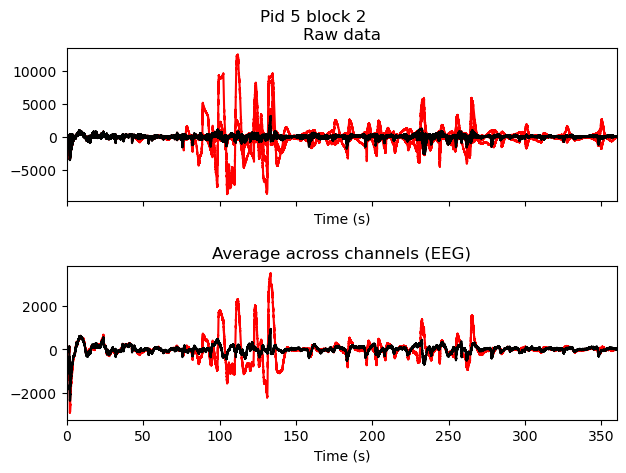

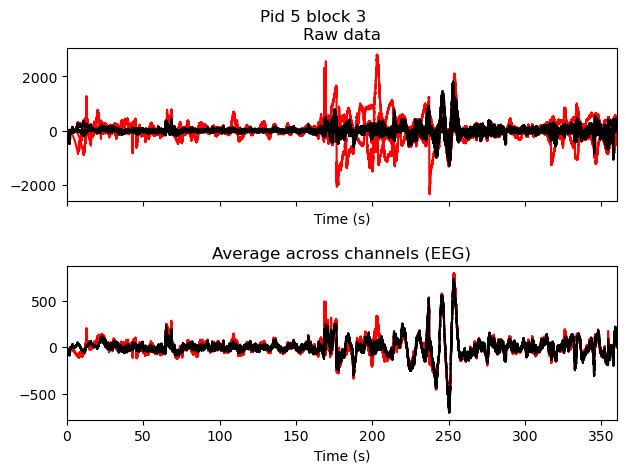

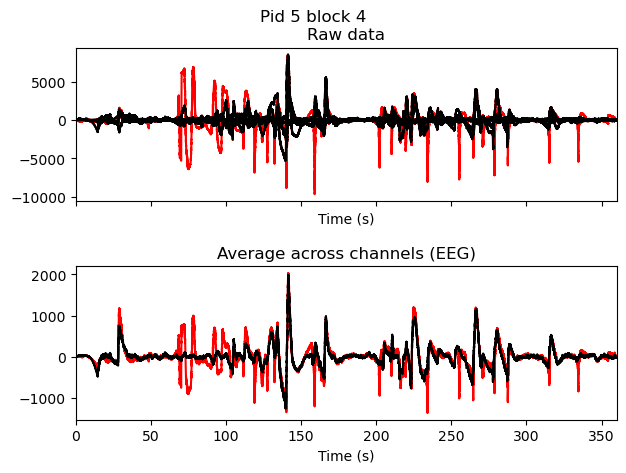

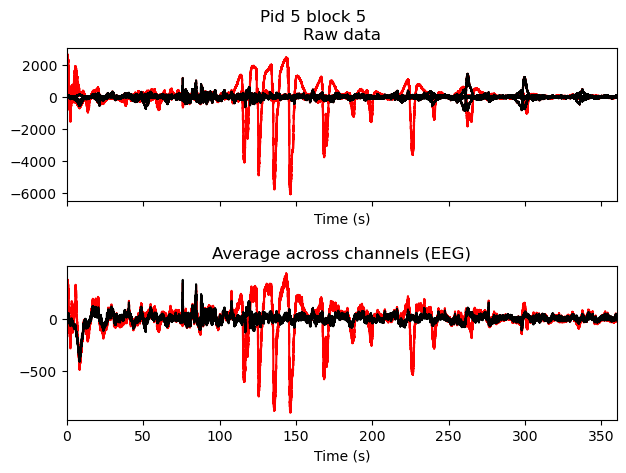

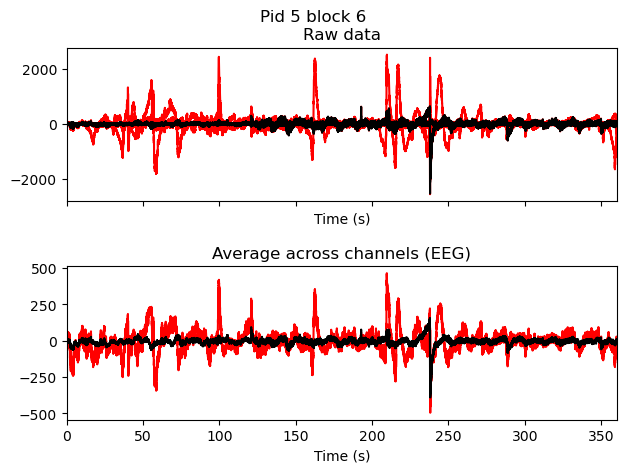

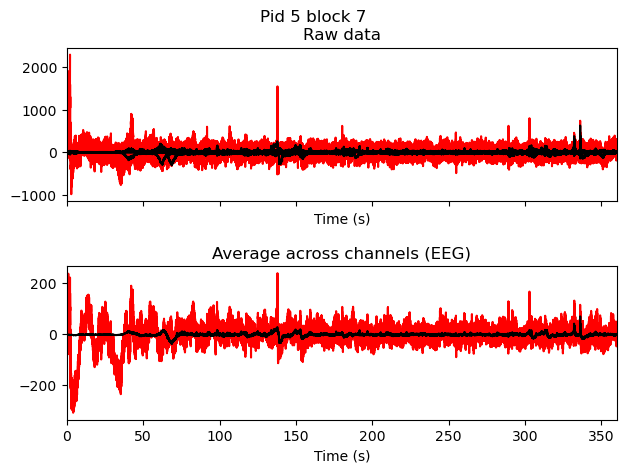

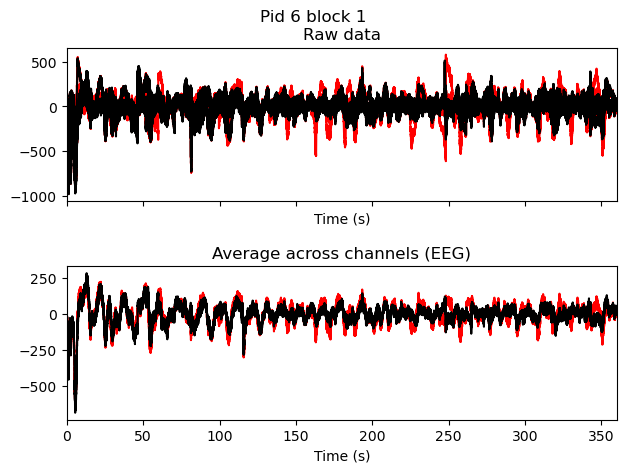

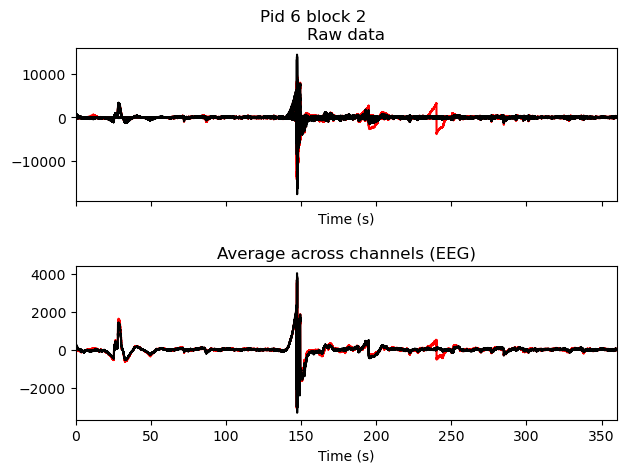

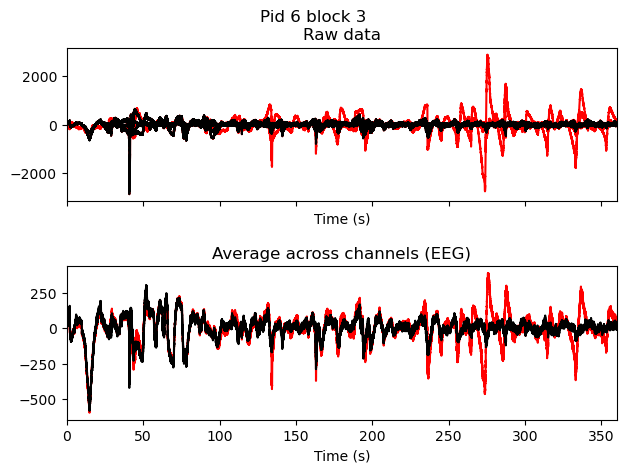

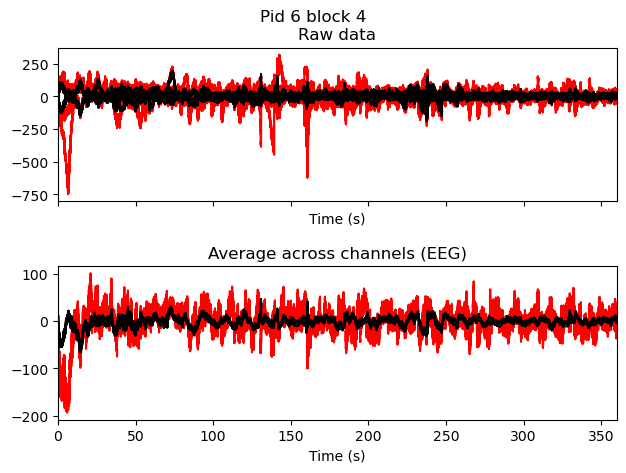

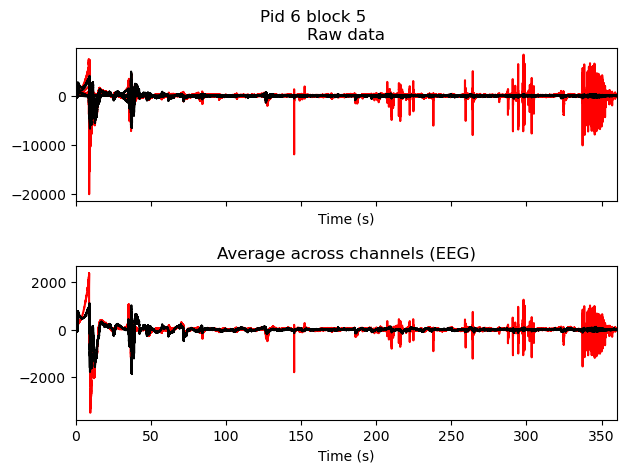

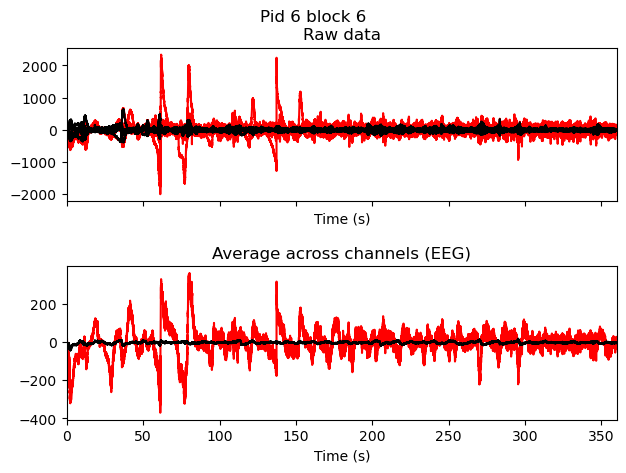

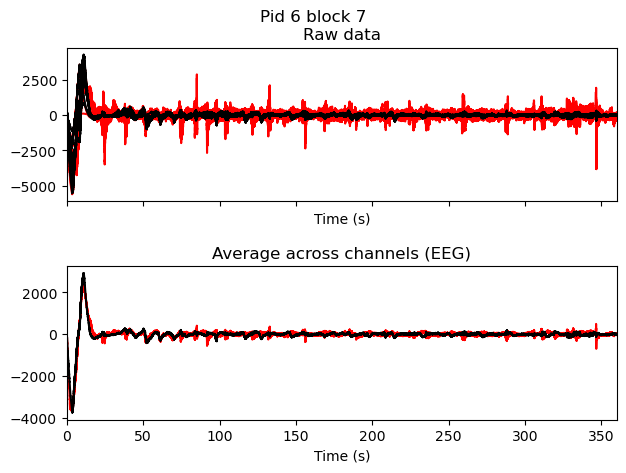

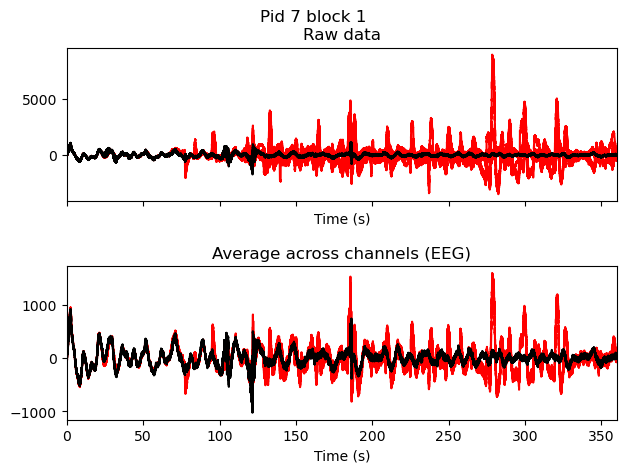

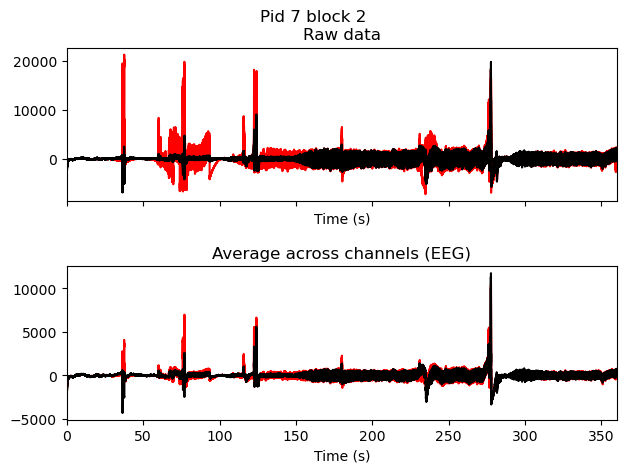

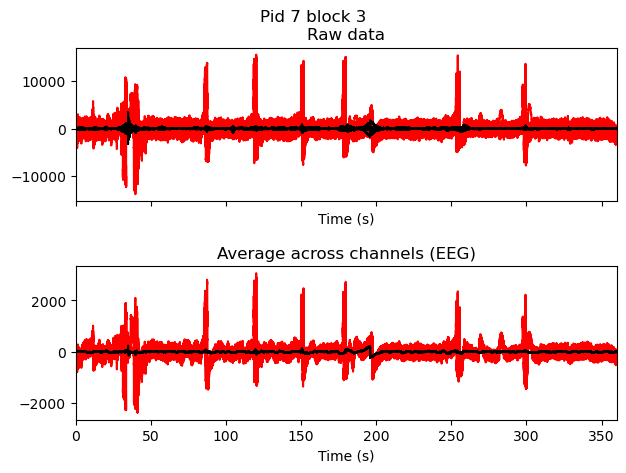

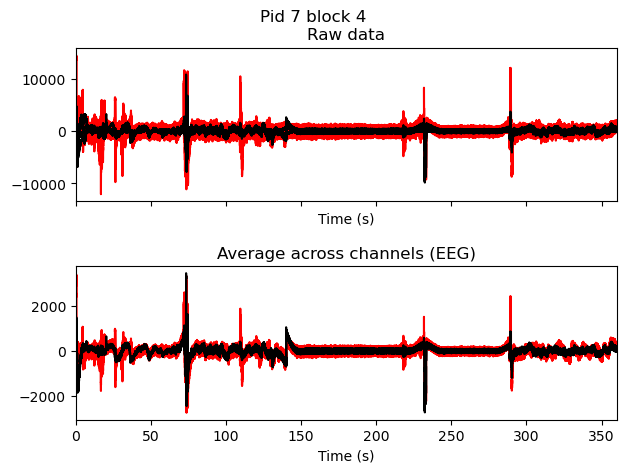

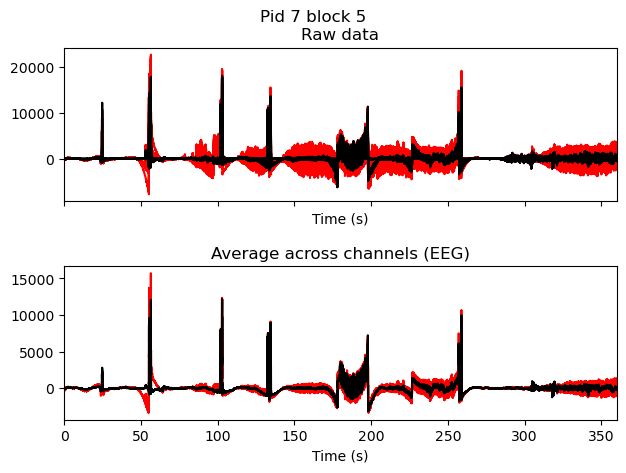

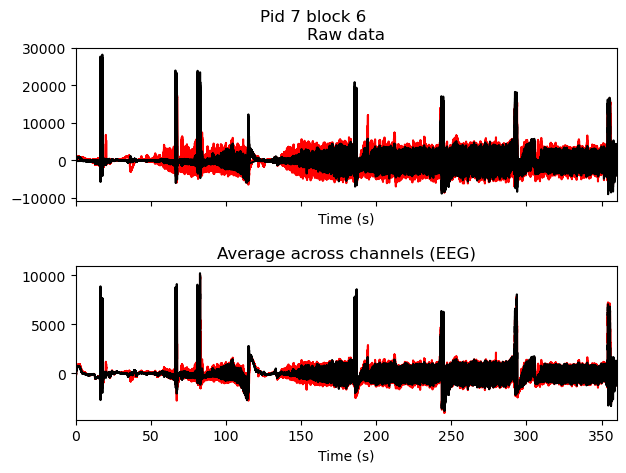

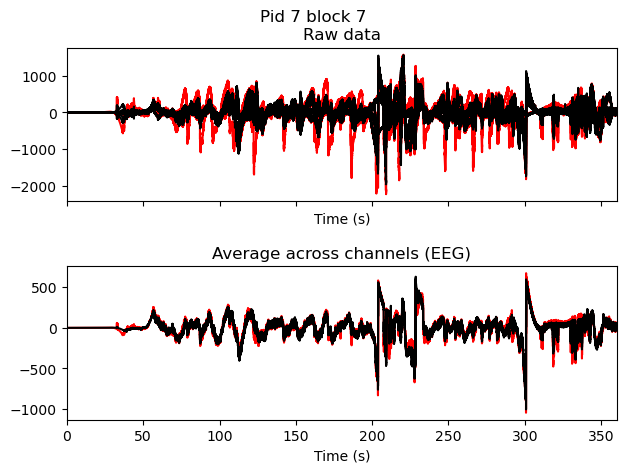

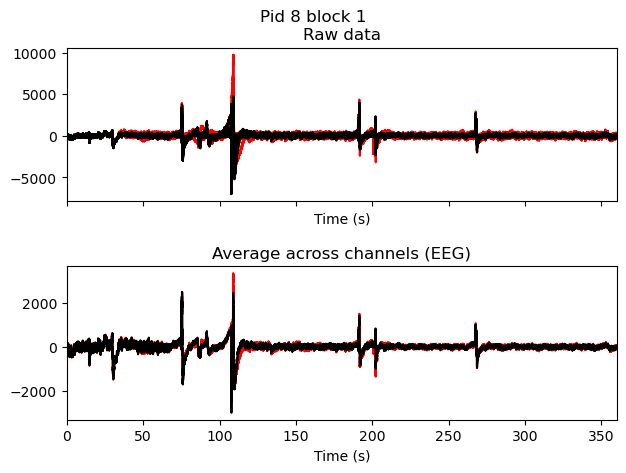

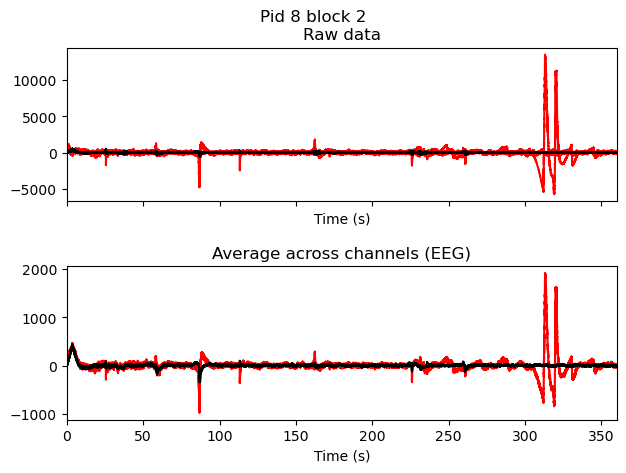

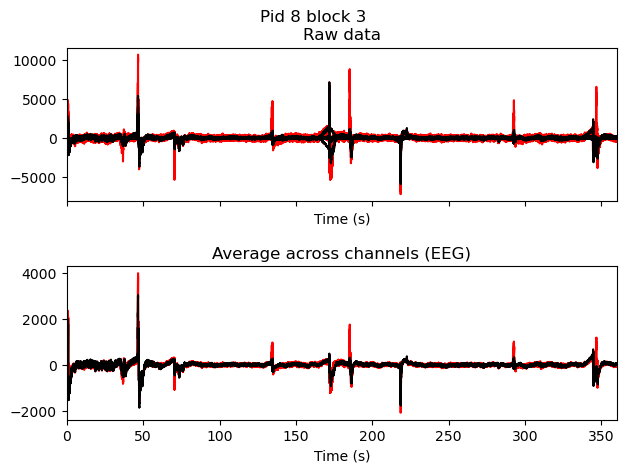

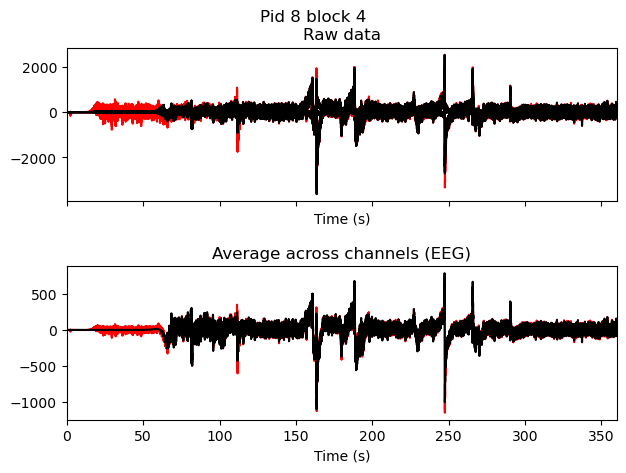

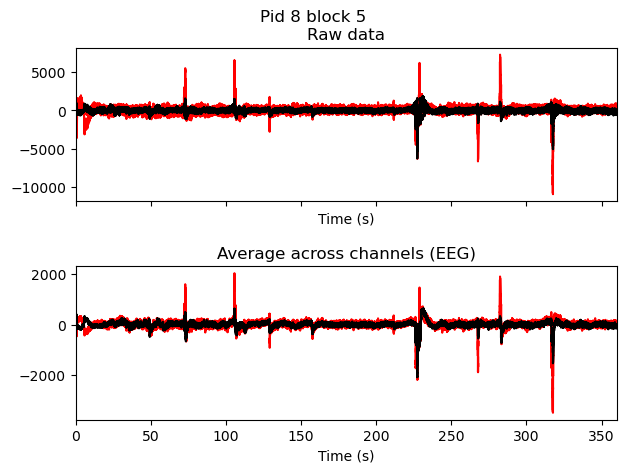

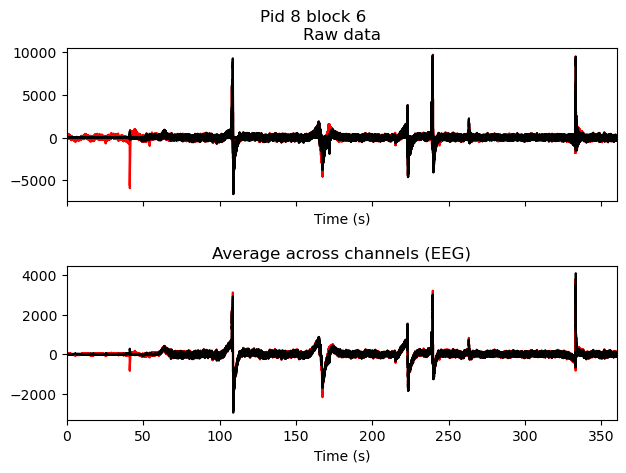

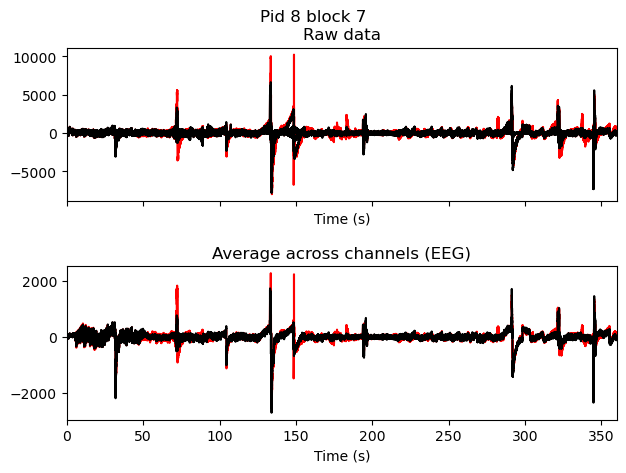

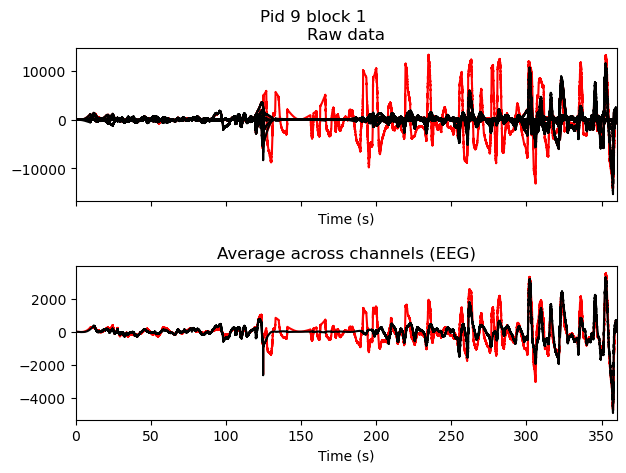

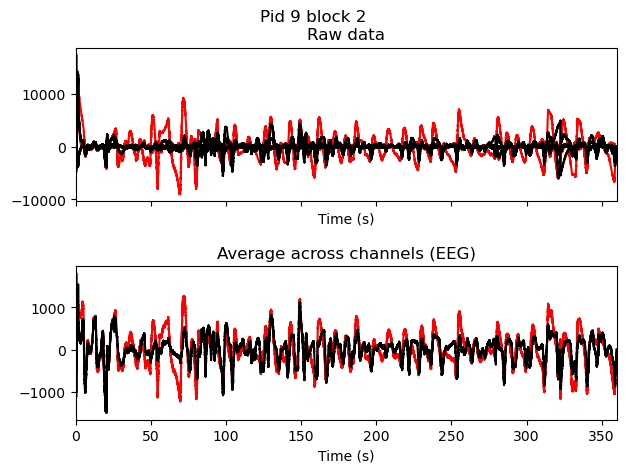

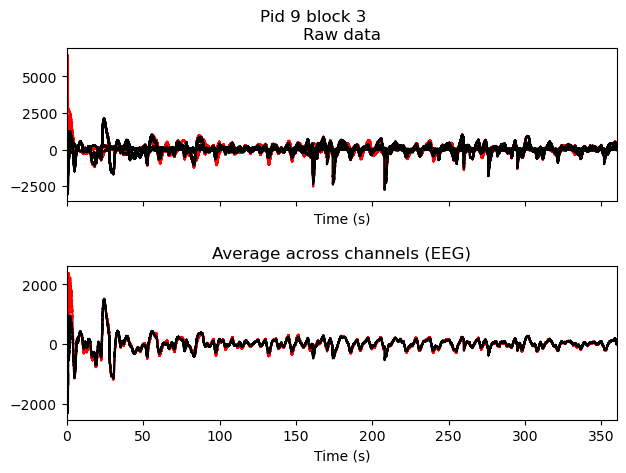

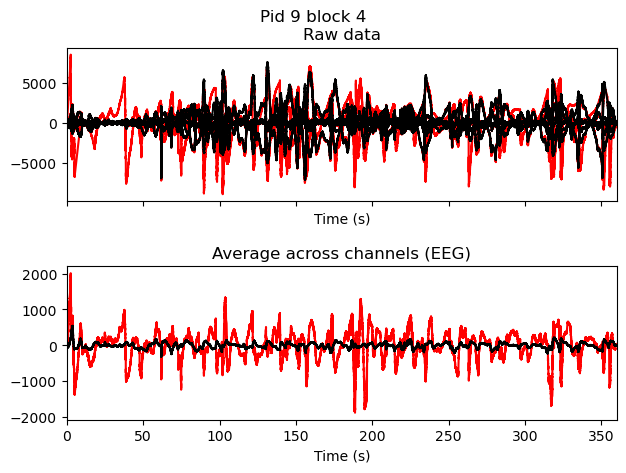

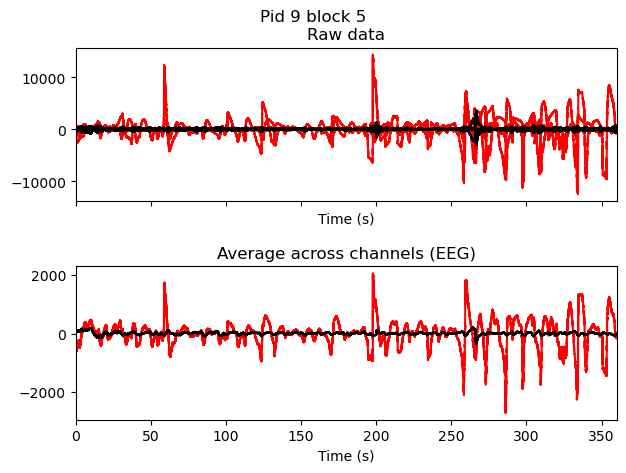

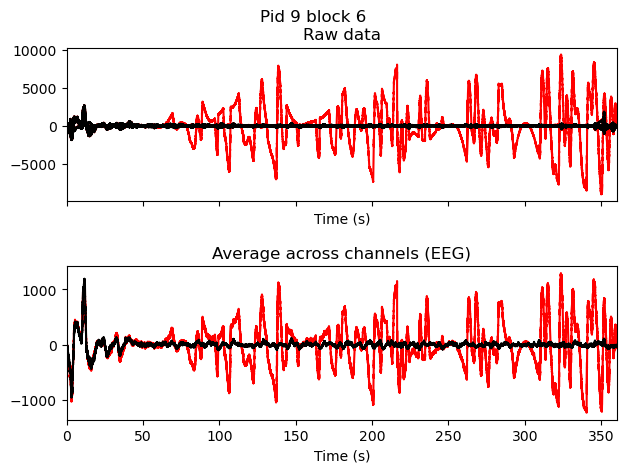

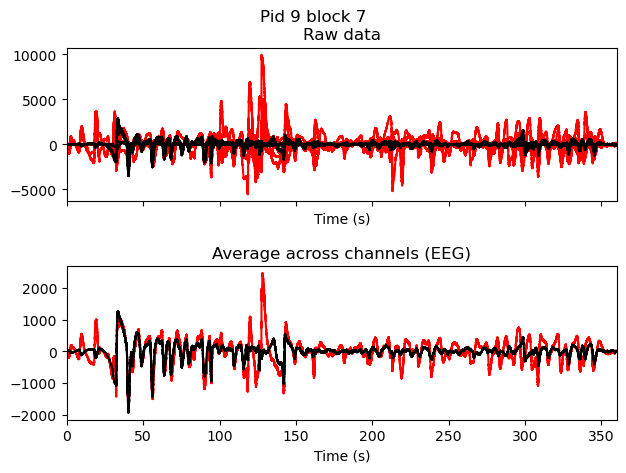

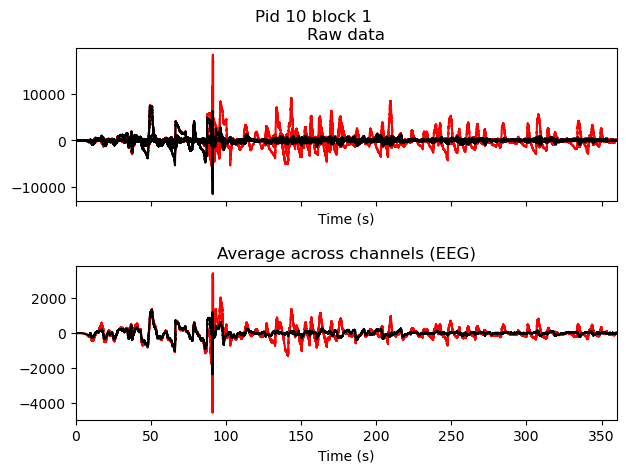

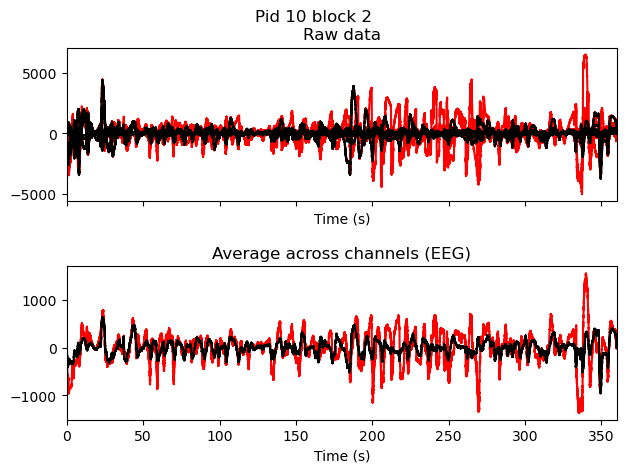

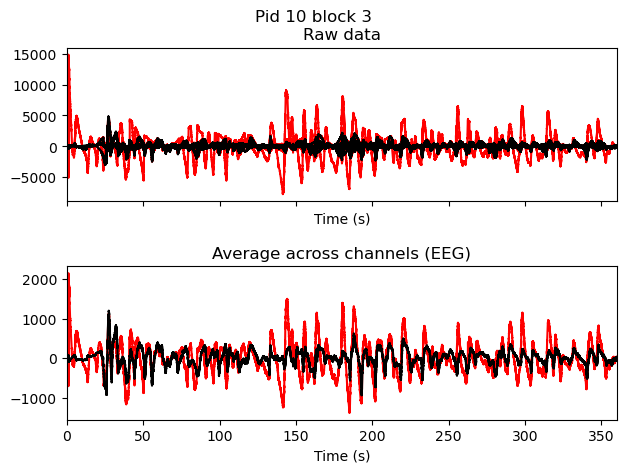

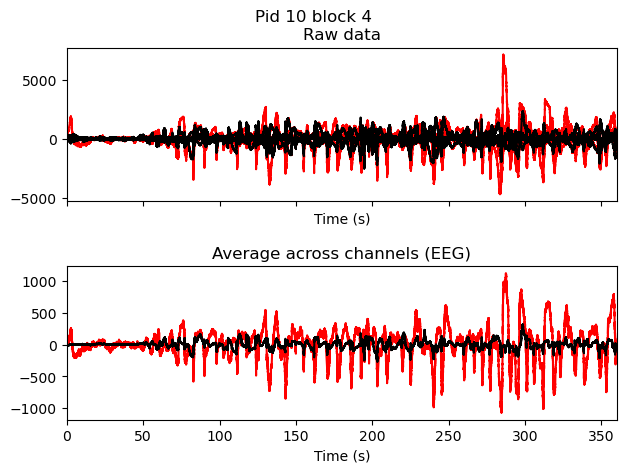

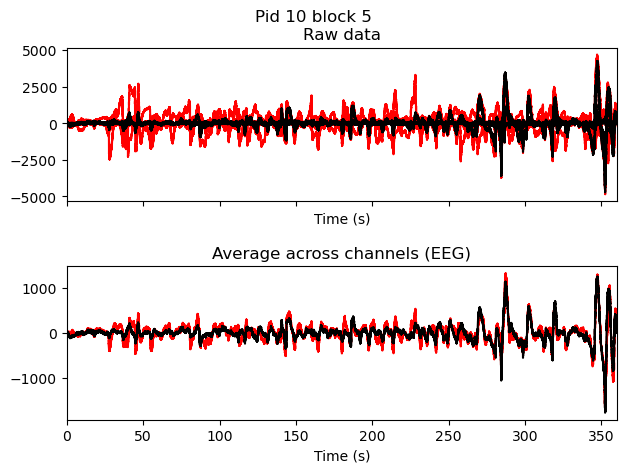

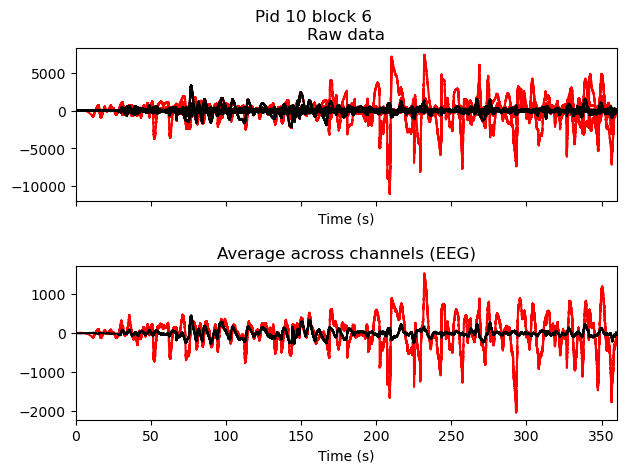

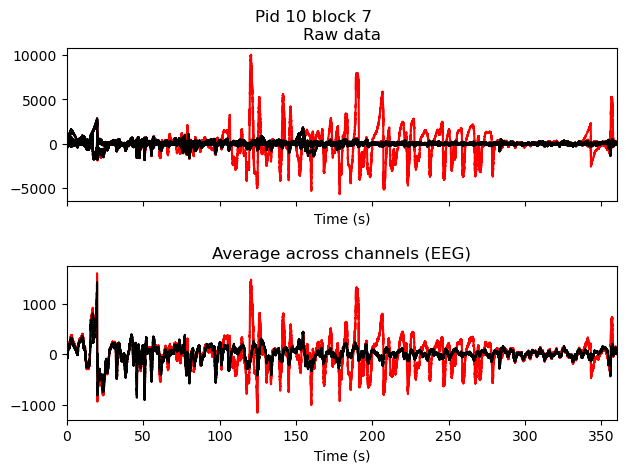

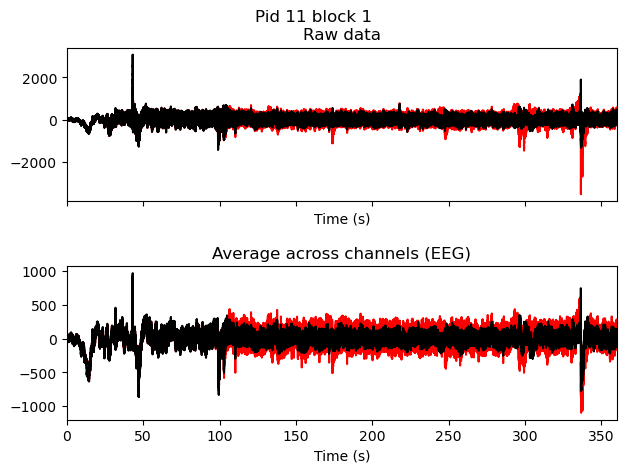

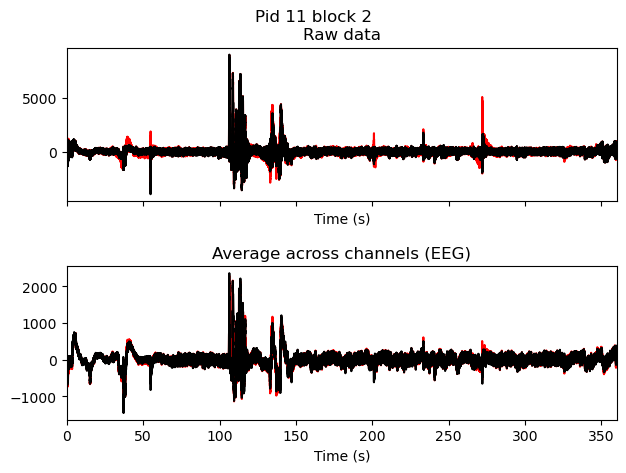

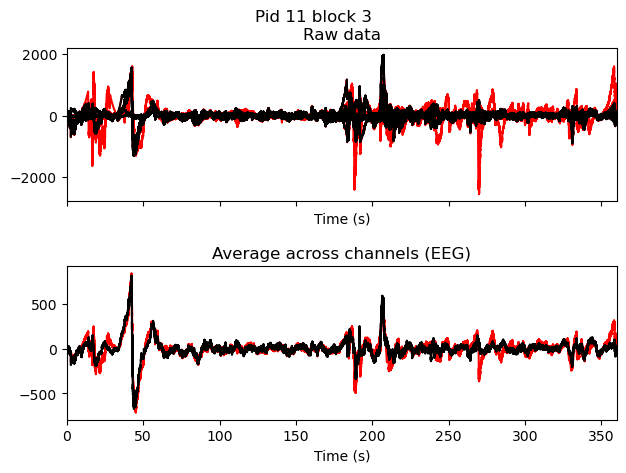

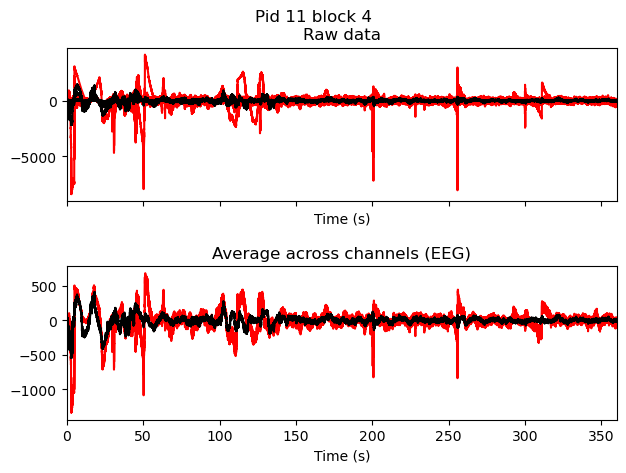

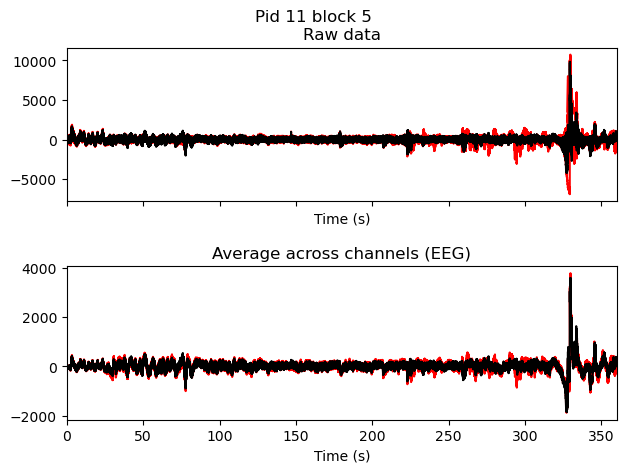

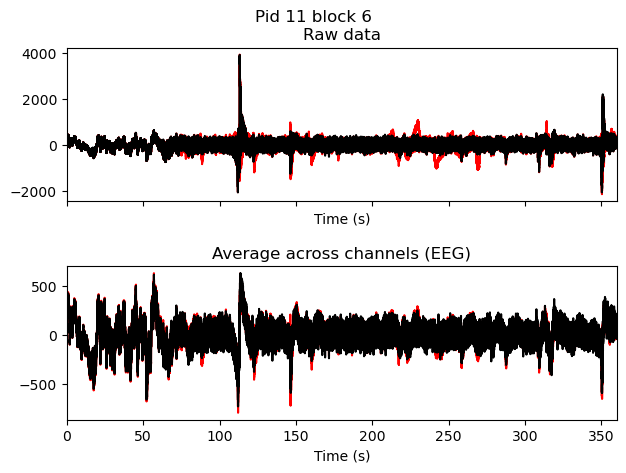

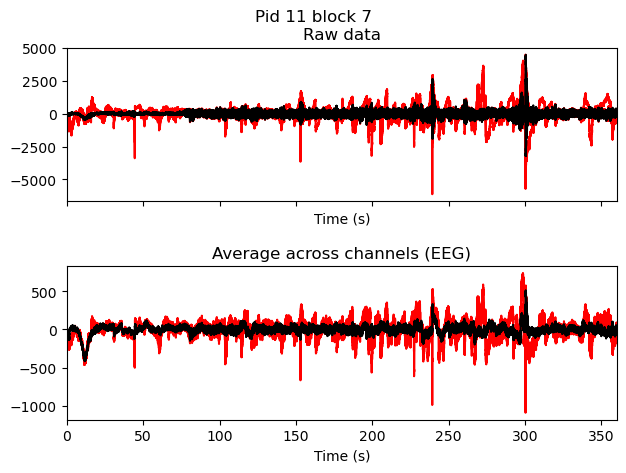

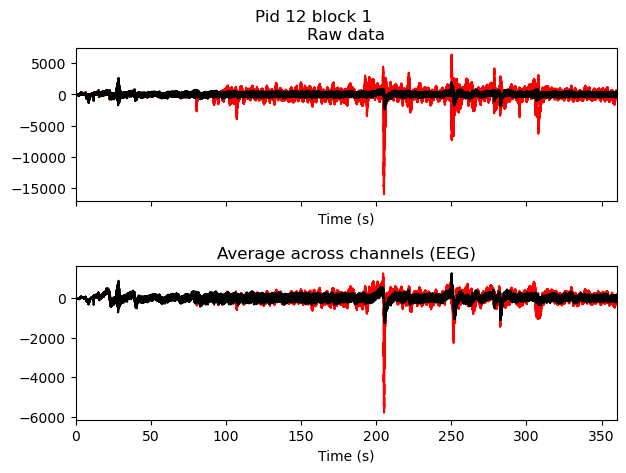

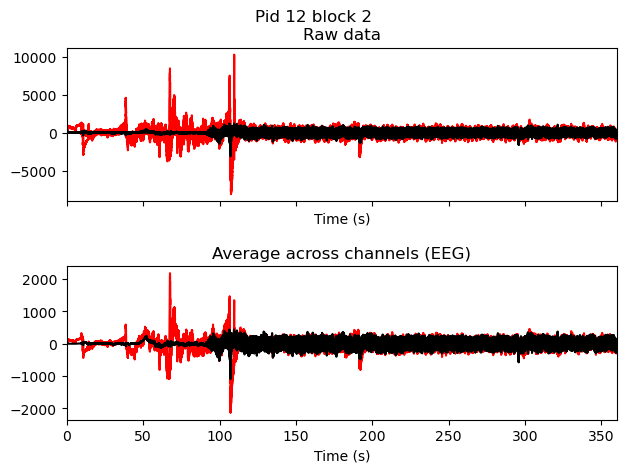

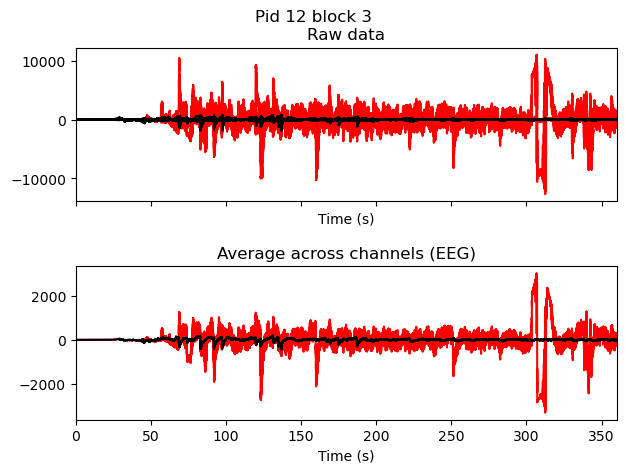

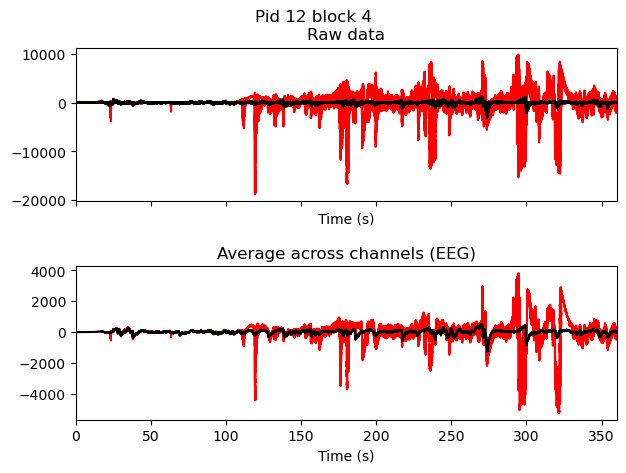

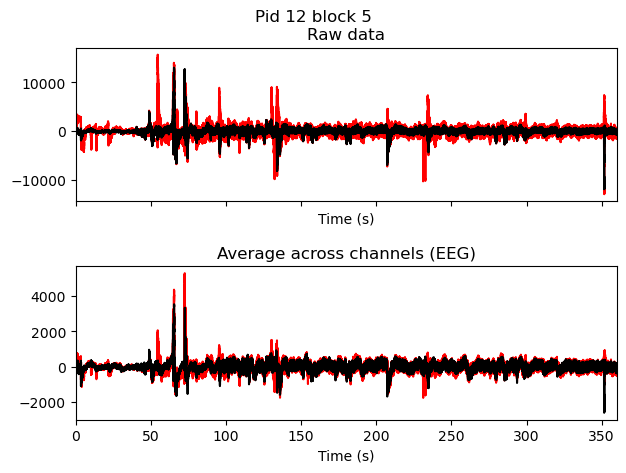

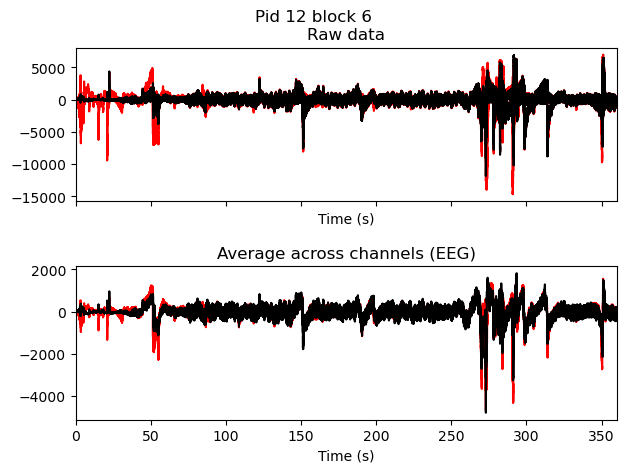

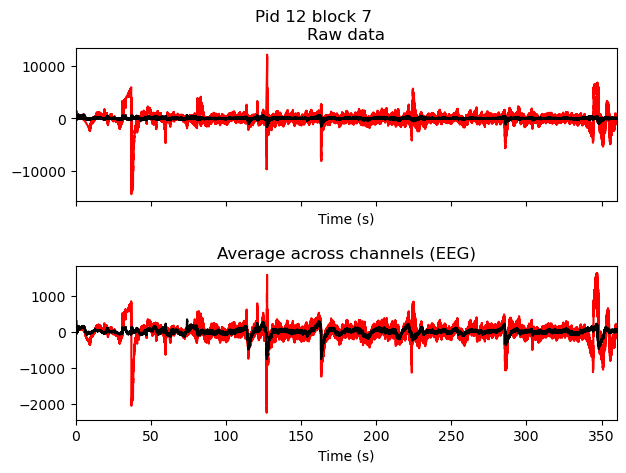

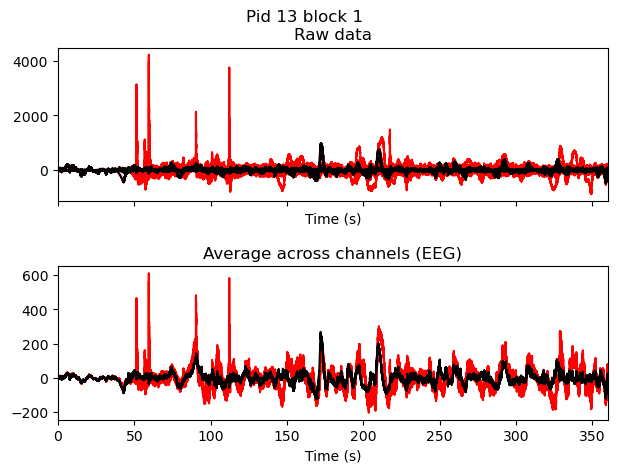

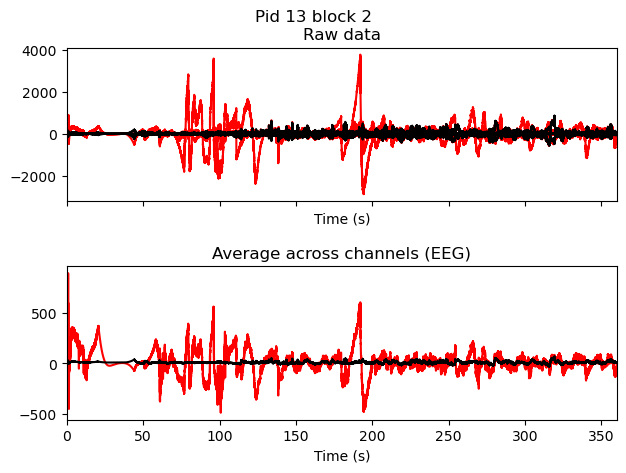

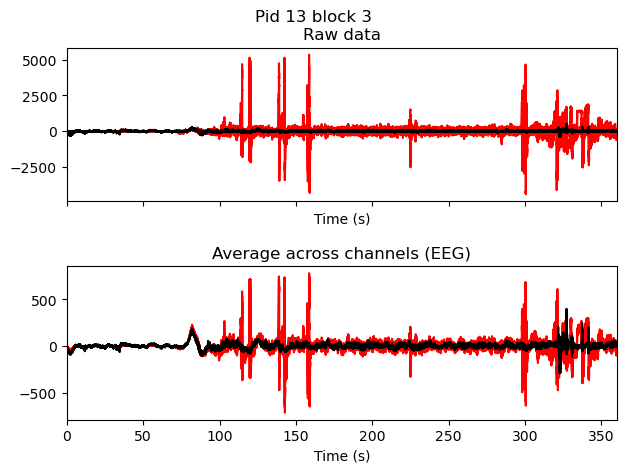

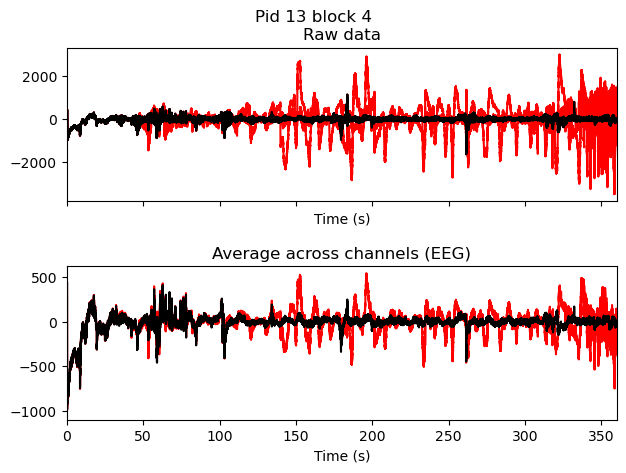

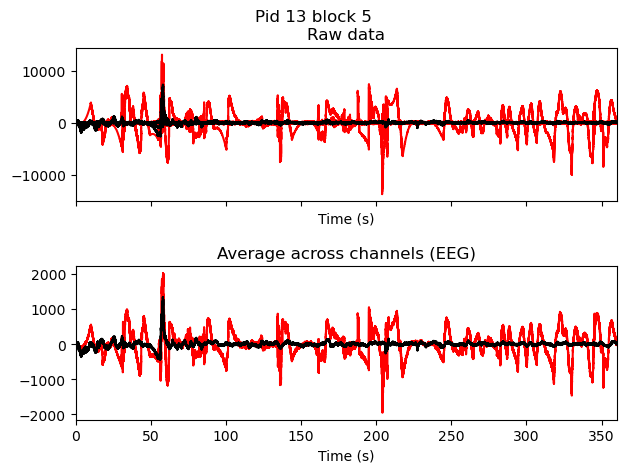

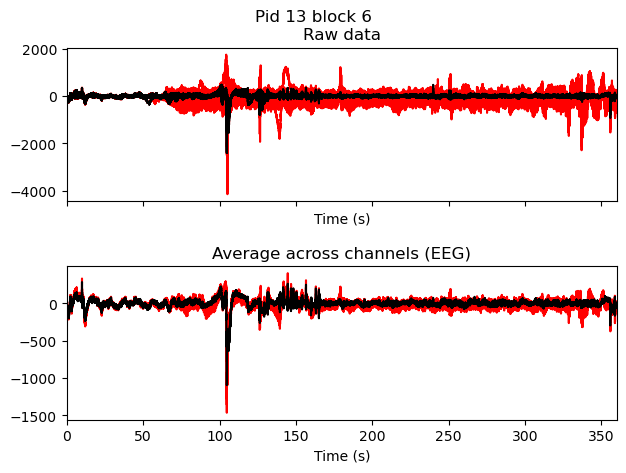

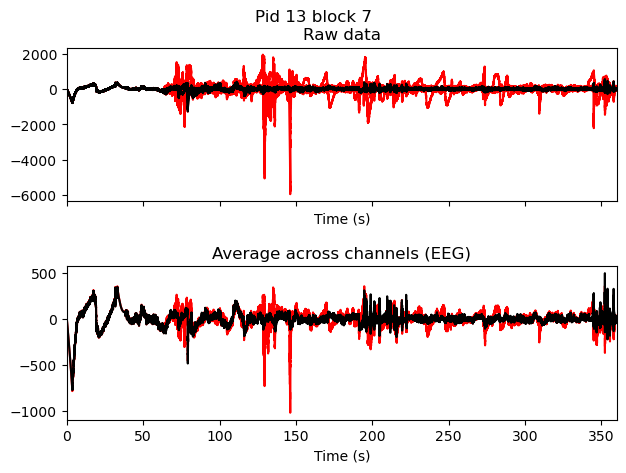

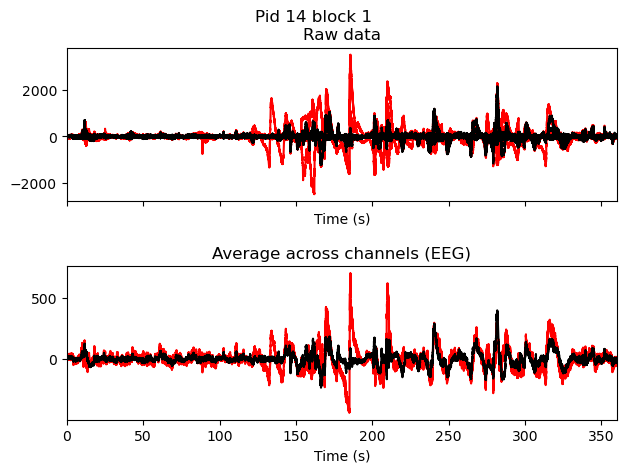

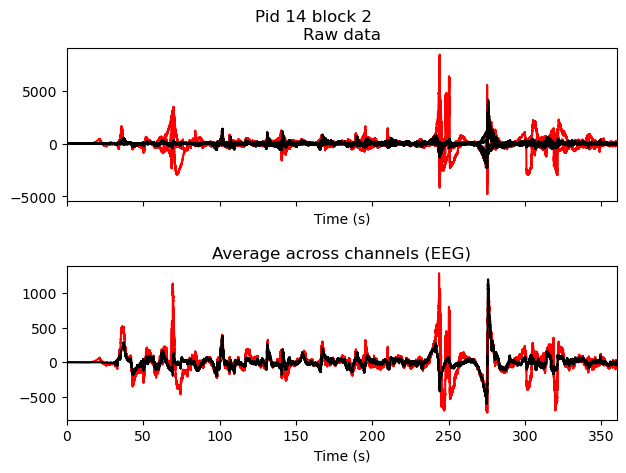

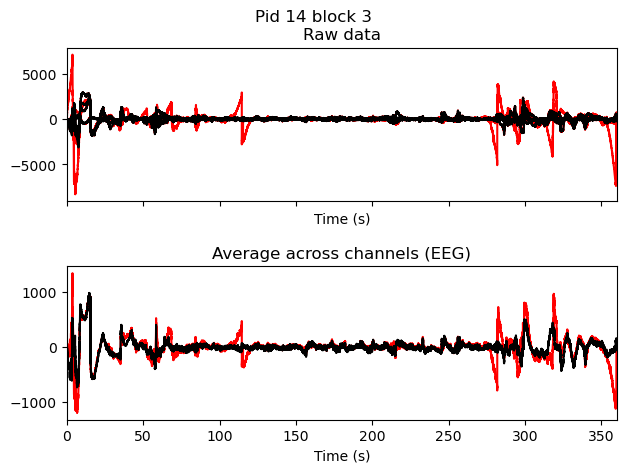

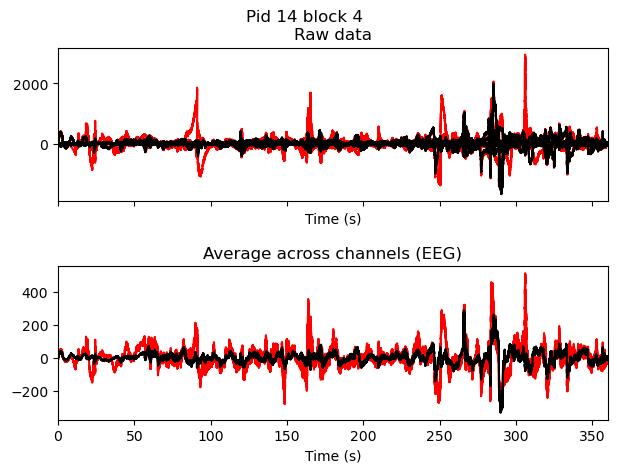

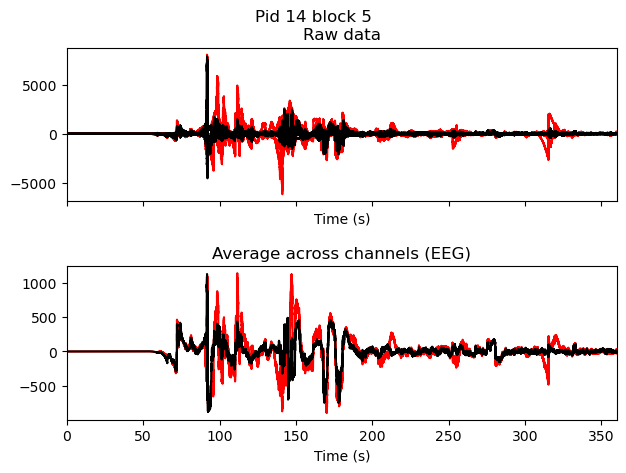

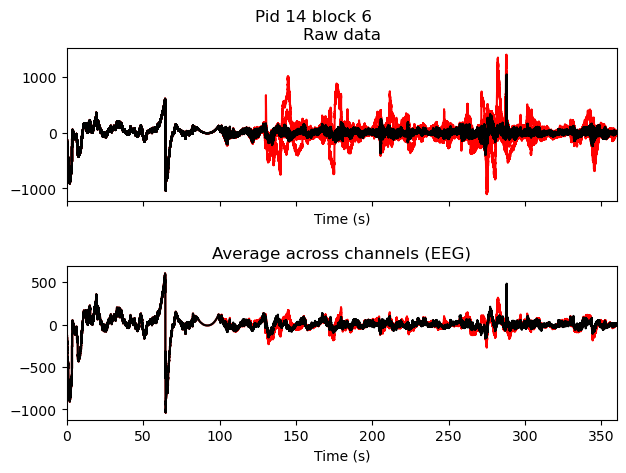

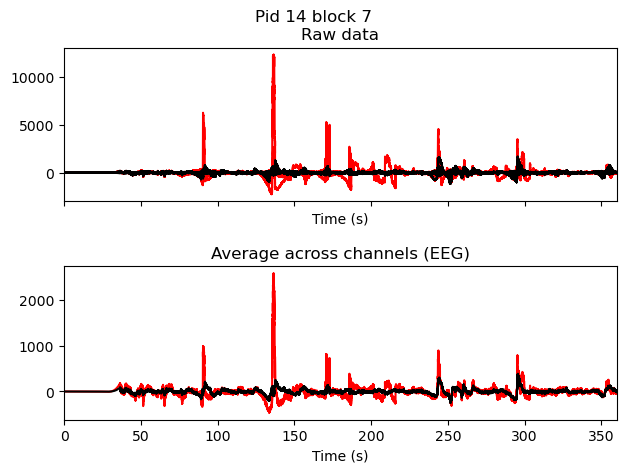

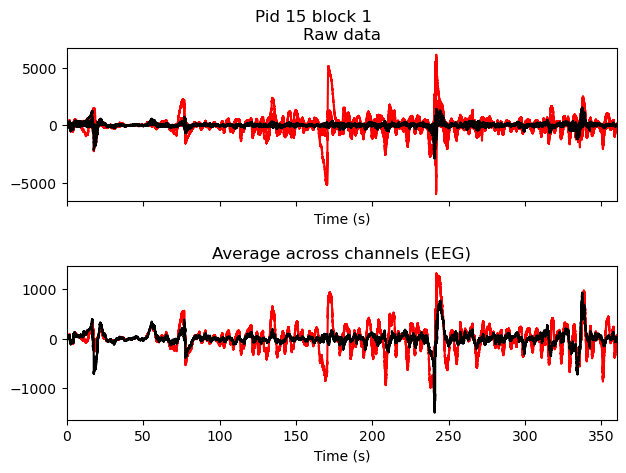

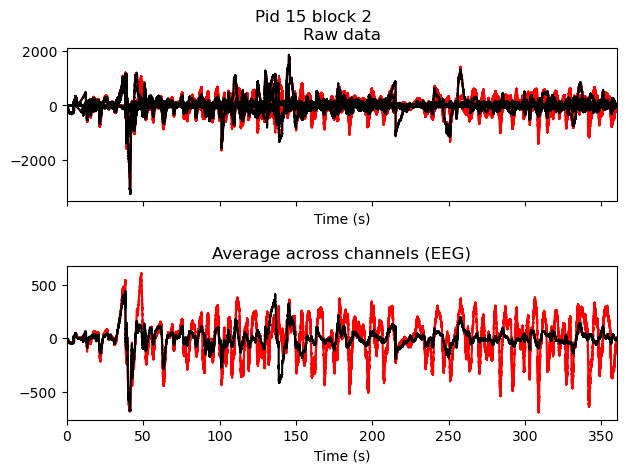

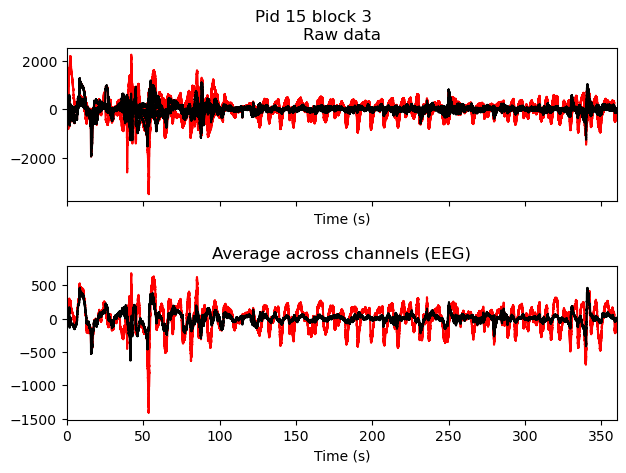

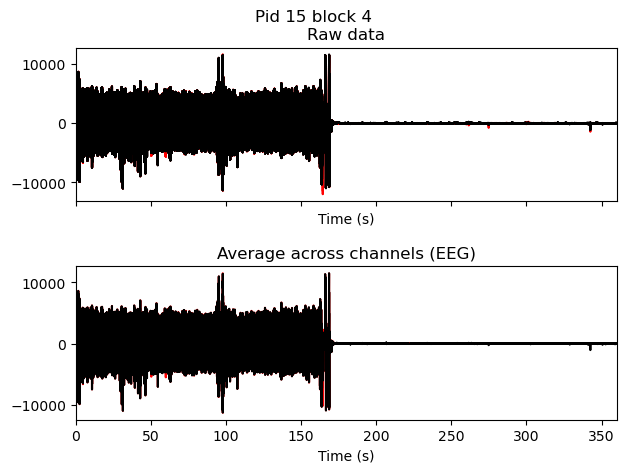

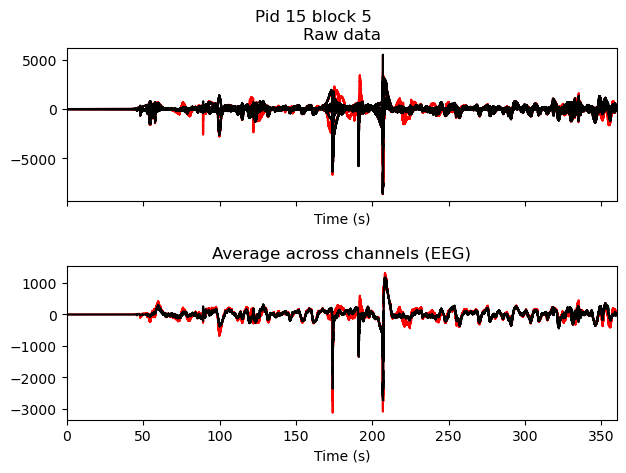

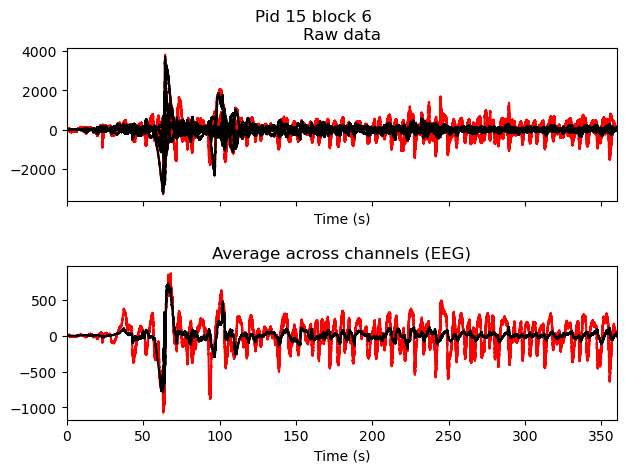

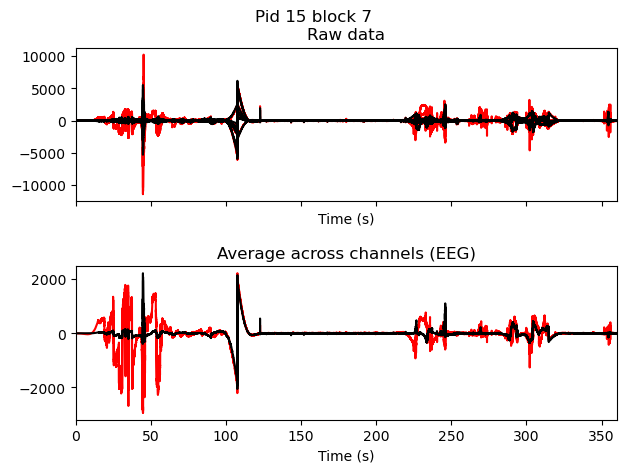

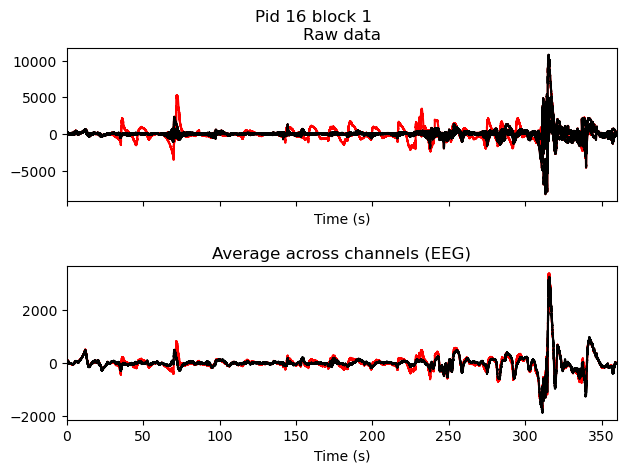

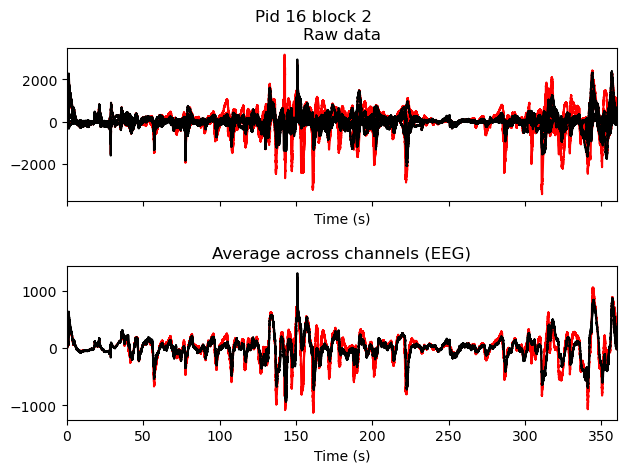

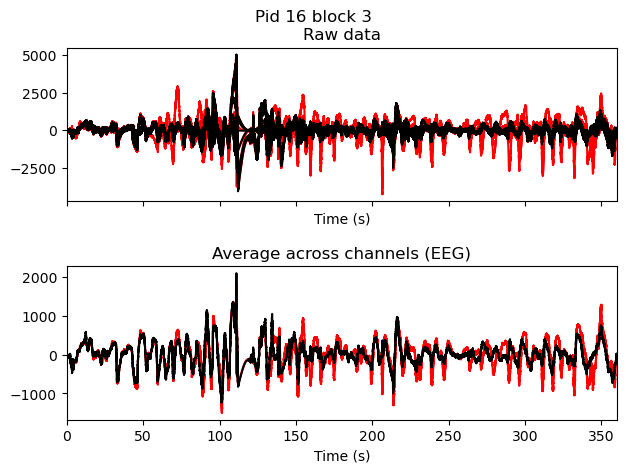

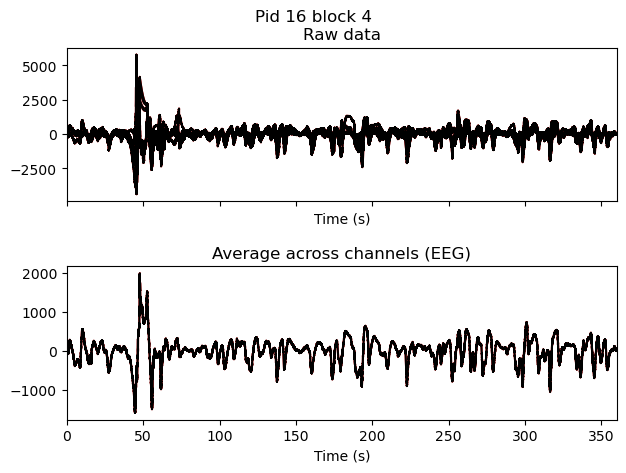

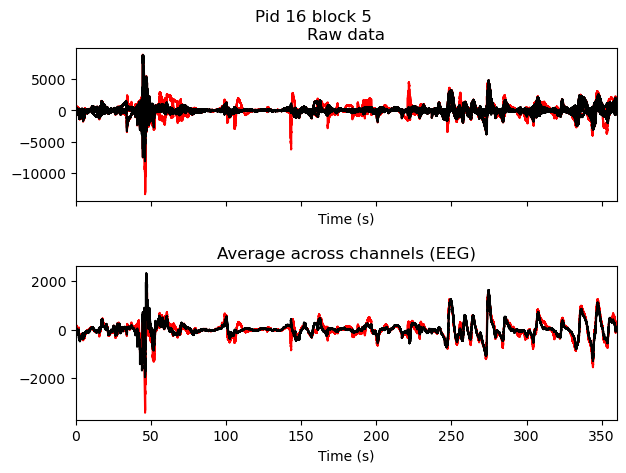

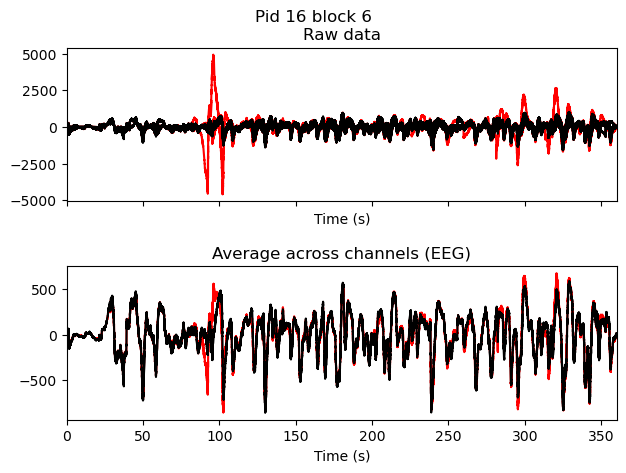

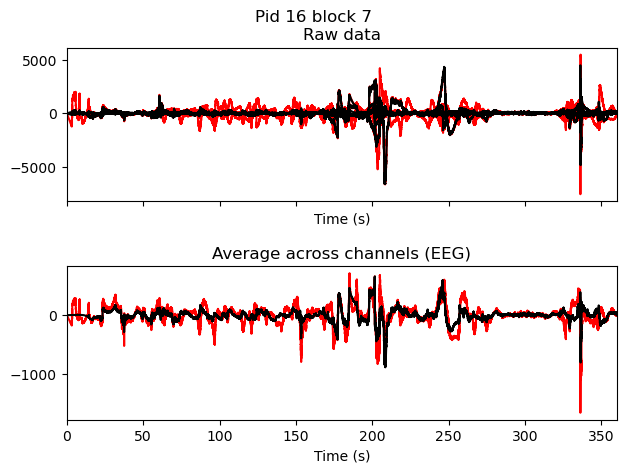

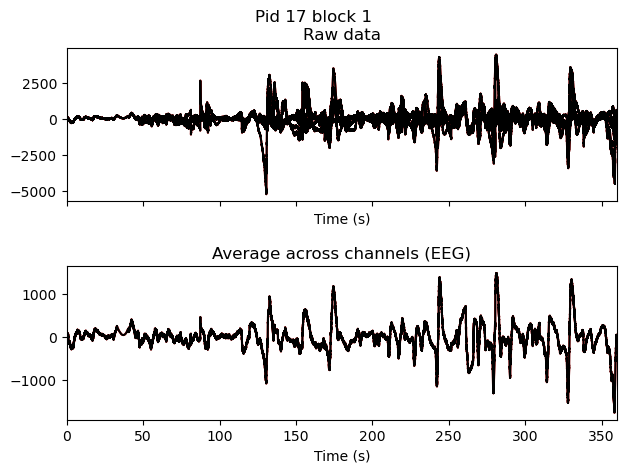

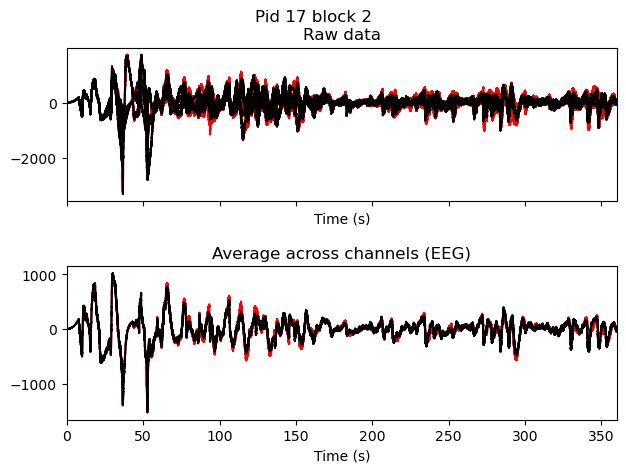

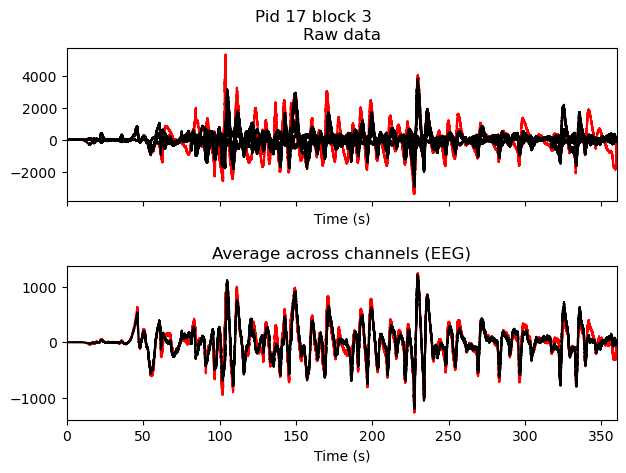

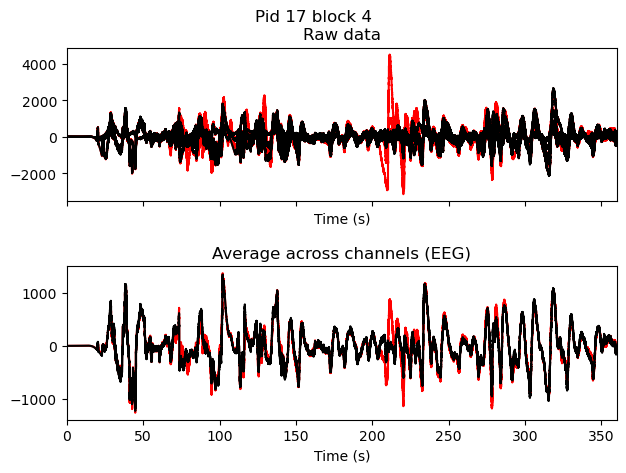

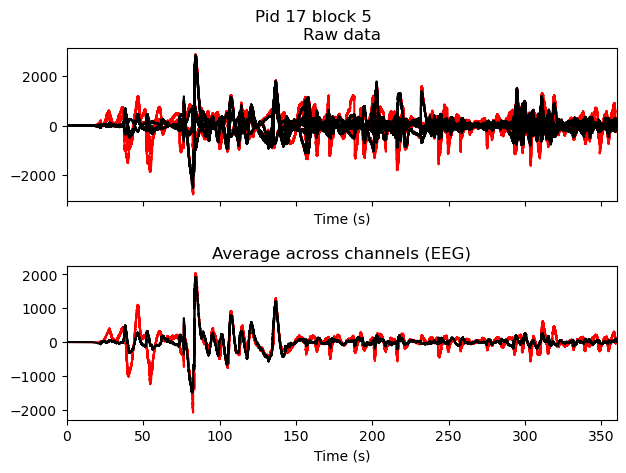

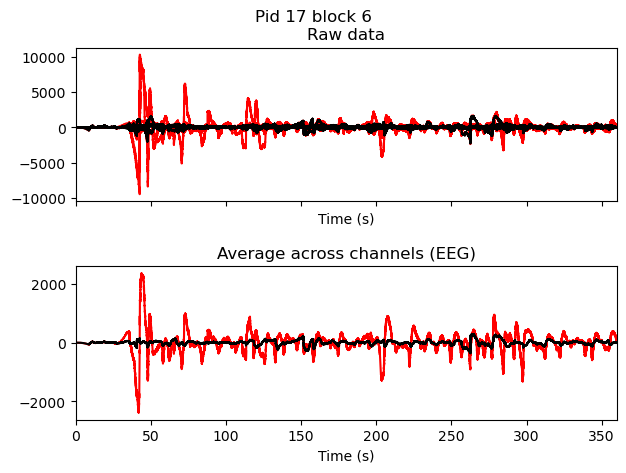

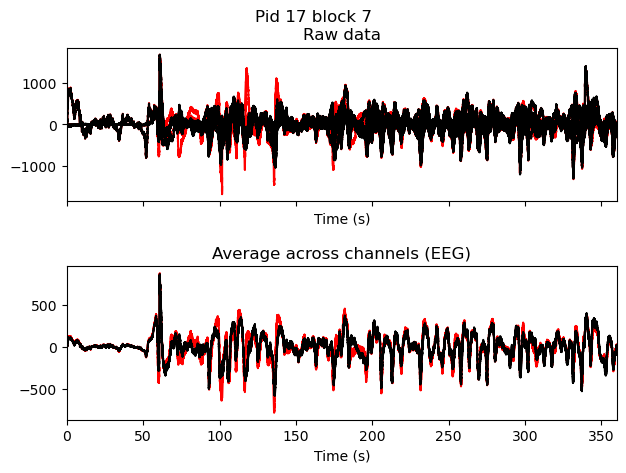

In [8]:
#clean_raws = np.zeros((2, 2),dtype=object)
clean_raws = np.zeros((len(lstPIds), NUM_BLOCKS),dtype=object)

for n, ic_templ in enumerate(ica_templates):
    icas.insert(0,ic_templ) #first element of ica array is the template
    for x, excl in enumerate(ica_excludes[n]):
        mne.preprocessing.corrmap(icas, [0,excl], label='exclude', plot=False)
    icas.pop(0) # remove template.

p = 0
b = 0
for i, n in enumerate(icas):
    b += 1
    p = p + 1 if i % 7 == 0 else p
    b = 1 if  b == 8 else b

    n.plot_overlay(arr_raws[i], n.labels_['exclude'], picks='eeg',  title=("Pid "+ str(p) +" block " +str(b)), stop = 430.)
    n.exclude = n.labels_['exclude']
    n.apply(arr_raws[i]) # TODO at least i hope so, double check indices

# for whatever reason i cant do a reshape with the arr_raws array. works with epochs though, so..... 
for i in range(len(lstPIds)):
    for j in range(NUM_BLOCKS):
        clean_raws[i][j] = arr_raws[j%NUM_BLOCKS+i*NUM_BLOCKS]

# TODO save preprocessed raws        
#raw.save("./ica/pipeline_1/raw/"+str(pid)+"_"+str(x)+".fif")

In [9]:
pws_lst = list()
for n, pid in enumerate(tqdm.tqdm(lstPIds)):
    # if pid != 1:
    #     continue
    # if (pid > 2):
    #     break
    
    for x in range(1,NUM_BLOCKS+1):
        raw = clean_raws[n][x-1]
        #raw = raw_dict[str(pid)+'-'+ str(x)]

        #plot alpha and theta 
        if(plot_plots):
            
            fig = plt.figure( figsize=(7, 3))
            subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[3., 1.])
            axs0 = subfigs[0].subplots(2, 1)
            subfigs[0].set_facecolor('0.9')

            raw.compute_psd(method='multitaper', fmin=4, fmax = 8).plot(dB=False, axes = axs0[1], show = False)
            raw.compute_psd(method='multitaper', fmin=8, fmax = 12).plot(dB = False, axes = axs0[0], show = False) 
        
            axs1 = subfigs[1].subplots(2, 1)
            raw.compute_psd(method='multitaper', fmin=4, fmax = 8).plot_topo(dB = False, axes = axs1[0], show = False)
            raw.compute_psd(method='multitaper', fmin=8, fmax = 12).plot_topo(dB = False, axes = axs1[1], show = False)
            
            fig.set_constrained_layout(True)
            fig.suptitle("PID " + str(pid) + " block " + str(x))
            if(save_plots):
                filepath = "../Plots/PID_" + str(pid) + "-Block_" + str(x)  + "-raw_psd_topo.png"
                plt.savefig(filepath)

      
        ### Compute the power spectral density (PSD)
        
        group1 = raw.copy().pick_channels(['F3', 'F4'])
        group2 = raw.copy().pick_channels(['F3', 'F4', 'C3', 'C4'])
        group3 = raw.copy().pick_channels(['P3', 'Pz', 'P4'])
        
        raw_groups = [group1, group2, group3, raw.copy()]
        
        for grp_nr, raw_group in enumerate(raw_groups):
            raw = raw_group 

            picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                    stim=False)
                    
            methods = ['multitaper', 'welch']
    
            for m, method in enumerate(methods):
                
                spectrum = raw.compute_psd(method= method)
                psds, freqs = spectrum.get_data(return_freqs=True)
                
                # Normalize the PSDs ?
                psds /= np.sum(psds, axis=-1, keepdims=True)
                
                # convert to dB
                #psds = 10 * np.log10(psds)
                
                #Mean of all channels
                psds_mean = psds.mean(0)
            
                freq_res = freqs[1] - freqs[0]
                
                # Find intersecting values in frequency vector
                idx_alpha = np.logical_and(freqs >= bands.alpha[0], freqs <= bands.alpha[1])
                idx_theta = np.logical_and(freqs >= bands.theta[0], freqs <= bands.theta[1])      
            
                # absolute power
                bp_alpha = simpson(psds_mean[idx_alpha], dx=freq_res)
                bp_theta = simpson(psds_mean[idx_theta], dx=freq_res) 
                bp_total = simpson(psds_mean, dx=freq_res)
                
                # relative power
                bp_alpha_rel =  bp_alpha / bp_total # alpha relative power
                bp_theta_rel = bp_theta / bp_total # theta relative power

                alpha_theta_total = bp_alpha / bp_theta
                alpha_theta_rel = bp_alpha_rel / bp_theta_rel       
                
                #peak power at freq
                peak_alpha = freqs[np.argmax(psds_mean[idx_alpha])]
                peak_theta = freqs[np.argmax(psds_mean[idx_theta])]

                # Extract the power values from the detected peaks
                # Plot the topographies across different frequency bands
                
                if(plot_plots):

                    fig, axes = plt.subplots(2, 2, figsize=(7, 3))
                    for ind, (label, band_def) in enumerate(bands):
                        
                        # Create a topomap for the current oscillation bandca
                        raw.compute_psd(method=method).plot_topomap({label: band_def}, ch_type='eeg', cmap = 'viridis', show_names=True, normalize=True, axes=axes[0, ind], show=False)

                        idx = np.logical_and(freqs >= band_def[0], freqs <=  band_def[1])
                        axes[0,ind].set_title(method + " PSD topo " + label + ' power ' + str(channel_groups[grp_nr]), {'fontsize' : 7})

                        psds_std = (psds_mean[idx]).std(0)
                        peak = freqs[np.argmax(psds_mean[idx])]
                        axes[1,ind].plot(freqs[idx], psds_mean[idx], color='k')
                        axes[1,ind].fill_between(freqs[idx], psds_mean[idx] - psds_std, psds_mean[idx] + psds_std,
                                        color='k', alpha=.5)
                        axes[1,ind].set_title(method + " PSD " + label + ' power', {'fontsize' : 7})
                    
                    fig.suptitle("PID " + str(pid) + " block " + str(x) + " " + str(channel_groups[grp_nr]))
                    fig.set_constrained_layout(True)
                    
                    if(save_plots):
                        filepath = "../Plots/PID_" + str(pid) + "-Block_" + str(x) + "-Group_" + str(grp_nr) + ".png"
                        plt.savefig(filepath)
            
                pws_lst.append([pid, x, bp_alpha, bp_theta, alpha_theta_total, grp_nr, method])
                   
        if(draw_plots):

            plt.show()

100%|██████████| 17/17 [01:56<00:00,  6.84s/it]


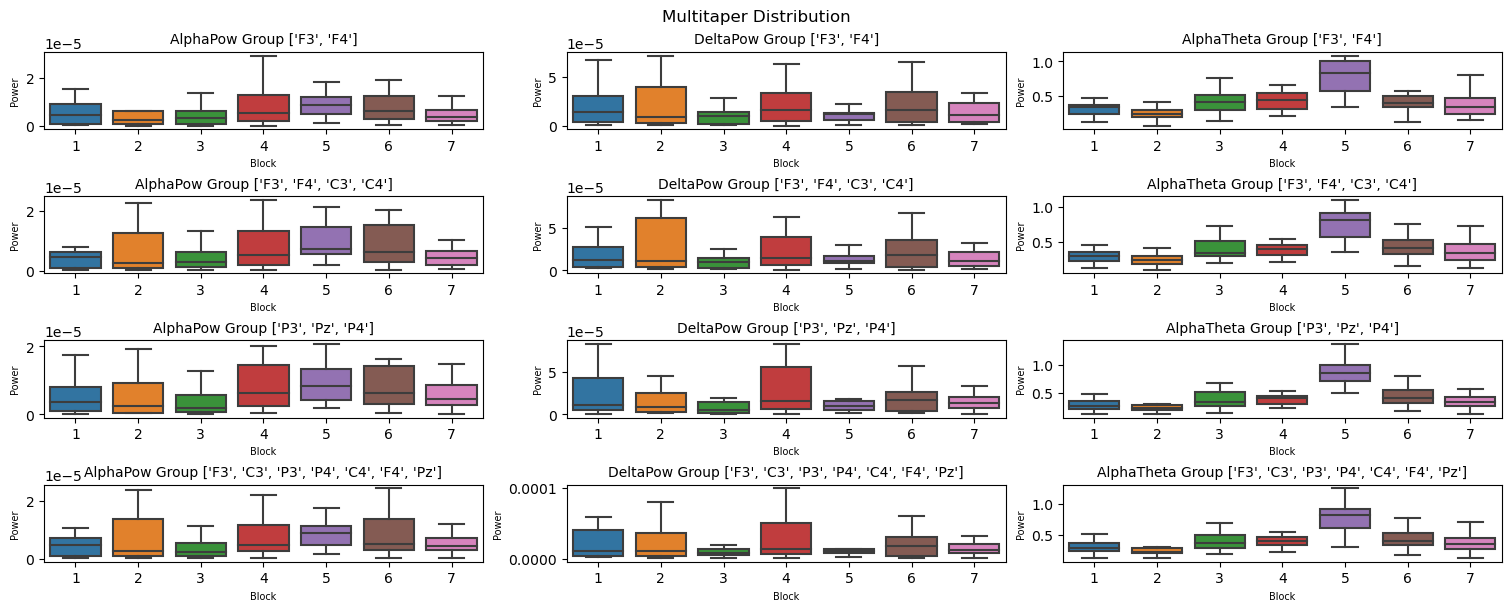

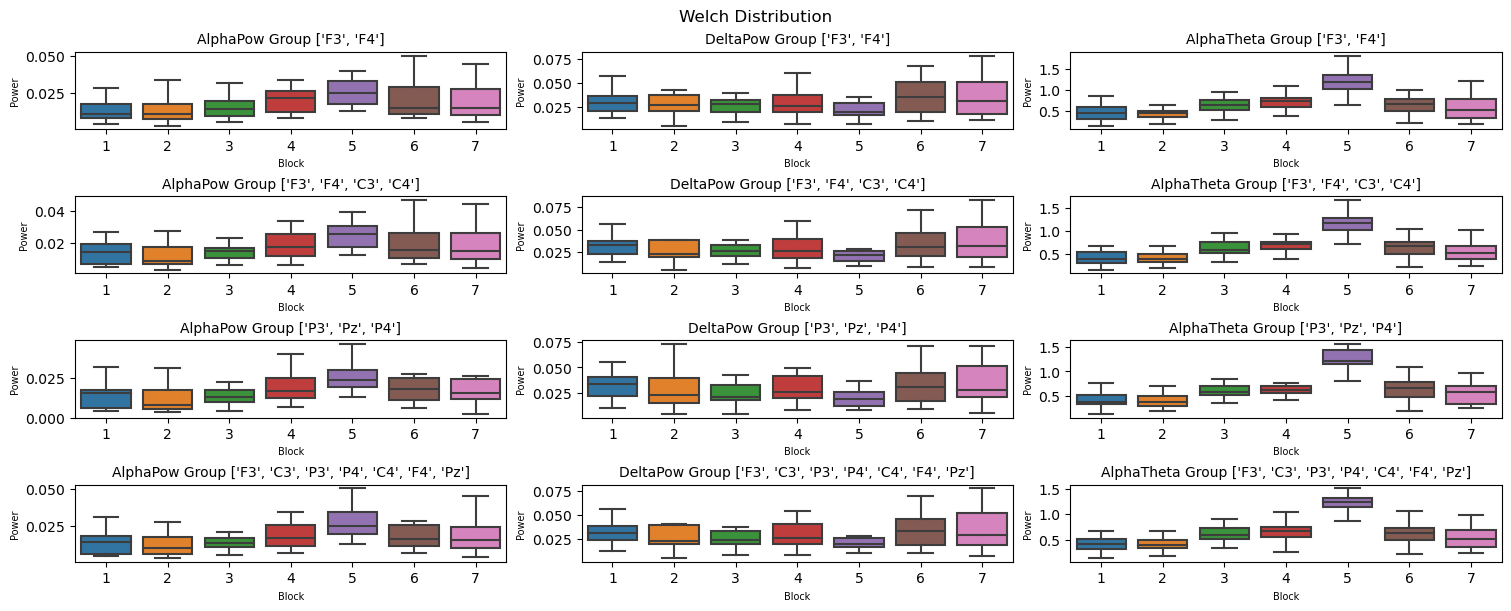

In [10]:
f, axes = plt.subplots(4, 3, figsize=(15,6), constrained_layout=True)
dfPowers = pd.DataFrame(pws_lst, columns =['PID', 'BlockNumber', 'AlphaPow', 'DeltaPow', 'AlphaTheta', 'Group', 'Method'])
ys = ['AlphaPow', 'DeltaPow', 'AlphaTheta']

for y in range(4):
    for i, ax1 in enumerate(axes[1]):
        sns.boxplot(x = "BlockNumber", y = ys[i], data = dfPowers.loc[(dfPowers['Group'] == y) & (dfPowers['Method'] == 'multitaper')], ax=axes[y,i],showfliers=False)
        #sns.stripplot(x="BlockNumber", y = ys[i], data=dfPowers.loc[(dfPowers['Group'] == y) & (dfPowers['Method'] == 'Multitaper')], marker="o", alpha=0.3, color="black", ax=axes[y,i])
        axes[y,i].set_title( str(ys[i]) + " Group " + str(channel_groups[y]), fontsize=10)
        axes[y,i].set_ylabel('Power', fontsize=7)
        axes[y,i].set_xlabel('Block', fontsize=7)
f.suptitle("Multitaper Distribution")

f, axes = plt.subplots(4, 3, figsize=(15,6), constrained_layout=True)
for y in range(4):
    for i, ax1 in enumerate(axes[1]):
        sns.boxplot(x = "BlockNumber", y = ys[i], data = dfPowers.loc[(dfPowers['Group'] == y) & (dfPowers['Method'] == 'welch')], ax=axes[y,i],showfliers=False)
        axes[y,i].set_title( str(ys[i]) + " Group " +  str(channel_groups[y]), fontsize=10)
        axes[y,i].set_ylabel('Power', fontsize=7)
        axes[y,i].set_xlabel('Block', fontsize=7)
f.suptitle("Welch Distribution")

plt.show()